In [15]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3,0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3,0


In [17]:
import sys
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import spectral_clustering
from sklearn.svm import SVC
import os

# requires pytorch > 0.3.1

import torch
import torch.nn as nn
from torch.autograd import Variable


# import the code, add path first
# for example
# solver_path = 'D:\local_github\notebook\AffinityNet1'
# if os.path.exists(solver_path):
#   sys.path.append(solver_path)

# try:
#   from AffinityNet1.utils.solver import Solver
#   from affinitynet.graph_attention import *
#   from affinitynet.test_graph_attention import *
# except ModuleNotFoundError:
#   pass

from utils.solver import Solver
from affinitynet.graph_attention import *
from affinitynet.test_graph_attention import *


# %load_ext autoreload
# %autoreload 2

In [19]:
use_gpu = True
if torch.cuda.is_available() and use_gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [20]:
seed = 0
signal_dim = 1
noisy_dim = 20
clu_size = 1000
num_clusters = 4
hidden_dims = [100]
num_iter = 100
batch_size = 100
lr = 1e-1
weight_decay = 1e-4
root = '.'
save_folder_prefix = '{0}/data/simulation/knn_pooling_toy/seed{1}'.format(root, seed)
# if not os.path.exists(save_folder_prefix):
#   os.makedirs(save_folder_prefix)
save_fig = False
figsize = 10

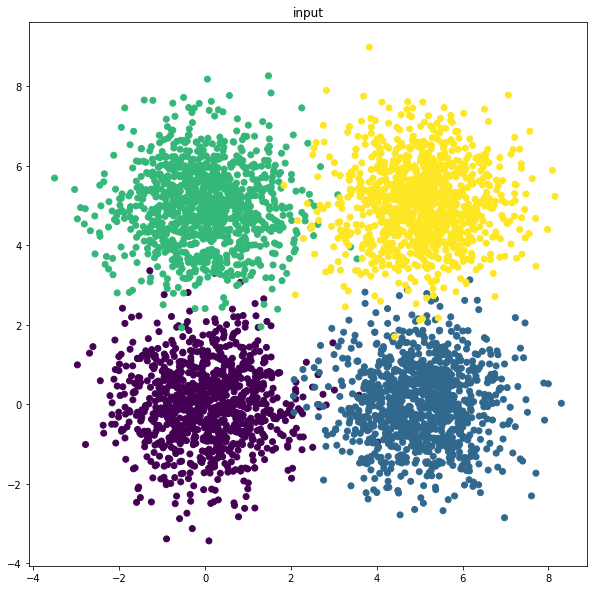

y: [0. 0. 0. ... 3. 3. 3.]
len(y): 4000
shape(y): (4000,)


In [33]:
means = np.array([[0,0], [1,0], [0,1], [1,1]]) * 5
assert num_clusters == len(means)
means = [m*signal_dim for m in means]
sigmas = 1.0*np.ones(len(means))
x = []
y = []
for i, (mean, sigma) in enumerate(zip(means, sigmas)):
    x.append(np.random.multivariate_normal(mean, sigma*np.eye(len(mean)), size=clu_size))
    y.append(i*np.ones(clu_size))
x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)

title = 'input'
plt.figure(figsize=(figsize, figsize))
plt.scatter(x[:,0], x[:,1], c=y)
save_folder = save_folder_prefix
if save_fig:
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig('{0}/{1}.png'.format(save_folder,title), bbox_inches='tight', dpi=200)
else:
    plt.title(title)
    plt.show()
plt.close()

print("y:",y)
print("len(y):",len(y))
print("shape(y):",y.shape)

## Purely unsupervised clustering (same as Graph Convolutional Neural Network)

In [ ]:
in_dim = x.shape[1]
x_var = Variable(torch.from_numpy(x).float())
y_var = Variable(torch.from_numpy(y).long())
num_cls = y_var.data.max().item()+1

model = MultiviewAttention(in_dim=in_dim, hidden_dims=[10, 10, 10], k=50, graph=None, 
                             out_indices=None, 
                   feature_subset=None, kernel='gaussian', nonlinearity_1=None,
                   nonlinearity_2=None, use_previous_graph=True, 
                             group_index=None, merge=None,
                  merge_type='affine', reset_graph_every_forward=False, 
                             no_feature_transformation=False, rescale=True, merge_dim=2, 
                          layer_norm=False)

features = FeatureExtractor(model.layers, selected_layers=range(len(model.layers)))
y_pred = features(x_var)

for i in range(len(y_pred)):
  plot_scatter(y_pred[i], title='y_pred[{0}]'.format(i), colors=y, 
               folder=save_folder, save_fig=save_fig, 
               size=figsize)

## Reproduce the results in the paper

In [44]:
z = np.random.multivariate_normal([2.5]*noisy_dim*2, 10*np.eye(noisy_dim*2), size=len(y))
x = np.concatenate([x[:,:signal_dim],z[:,:noisy_dim],x[:,signal_dim:],z[:,noisy_dim:]],axis=1)
in_dim = x.shape[1]

In [52]:
print(in_dim)

42


In [45]:
print(z.shape)
#print(z)
print(x.shape)

(4000, 40)
(4000, 42)


In [24]:
def compare_classifiers(X_train, X_test, y_train, y_test, names, classifiers, res=None):
  def eval_classifiers(X_test, y_test):
    acc_test = []
    nmi_test = []
    f1_score_test = []
    confusion_mat_test = []
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
        nmi = sklearn.metrics.adjusted_mutual_info_score(labels_true=y_test, labels_pred=y_pred)
        confusion_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)
        f1_score = sklearn.metrics.f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
        print('{0}: acc={1:.2f}, nmi={2:.2f}, f1={3:.2f}, confusion_mat:\n{4}'.format(name, acc, nmi, 
                                                                        f1_score, confusion_mat))
        acc_test.append(acc)
        nmi_test.append(nmi)
        f1_score_test.append(f1_score)
        confusion_mat_test.append(confusion_mat)
    return acc_test, nmi_test, f1_score_test, confusion_mat_test
  
  acc_test, nmi_test, f1_score_test, confusion_mat_test = eval_classifiers(X_test, y_test)
  acc_train, nmi_train, f1_score_train, confusion_mat_train = eval_classifiers(X_train, y_train)
  if res is not None:
    acc_test = acc_test + res['test']['acc']
    nmi_test = nmi_test + res['test']['nmi']
    f1_score_test = f1_score_test + res['test']['f1_score']
    confusion_mat_test = confusion_mat_test + res['test']['confusion_mat']
    acc_train = acc_train + res['train']['acc']
    nmi_train = nmi_train + res['train']['nmi']
    f1_score_train = f1_score_train + res['train']['f1_score']
    confusion_mat_train = confusion_mat_train + res['train']['confusion_mat']
  res = {'train': {'acc': acc_train, 'nmi': nmi_train, 'f1_score': f1_score_train, 
                  'confusion_mat': confusion_mat_train},
        'test': {'acc': acc_test, 'nmi': nmi_test, 'f1_score': f1_score_test, 
                  'confusion_mat': confusion_mat_test}}
  return res

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

names = ["Neural Net", "Decision Tree", "AdaBoost", "Nearest Neighbors", "Linear SVM", 
           "RBF SVM", "Random Forest", "Naive Bayes"]

classifiers = [
      MLPClassifier(alpha=1),
      DecisionTreeClassifier(max_depth=5),
      AdaBoostClassifier(),
      KNeighborsClassifier(3),
      SVC(kernel="linear"),
      SVC(gamma=2, C=1),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      GaussianNB()]

In [ ]:
def plot_feature_weight(feature_weight_all, colors, title):
  plt.figure(figsize=(figsize, figsize))
  plt.scatter(range(len(feature_weight_all)), feature_weight_all, c=colors, s=20)
  plt.xlabel('index')
  plt.ylabel('weight')
  if save_fig:
      if not os.path.exists(save_folder):
          os.makedirs(save_folder)
      plt.savefig('{0}/{1}.png'.format(save_folder,title), bbox_inches='tight', dpi=200)
  else:
      plt.title(title)
      plt.show()
  plt.close()

def plot_feature_weight_affinitynet(model_layers, title):
  print(title)
  feature_weight_all = np.ones(in_dim)
  for i in range(len(model_layers)):
      feature_weight = nn.functional.softmax(model_layers[i].components[0].a, 0).detach().cpu().data.numpy()
      print('layer{0}: {2}, {1}'.format(
          i, feature_weight[range(0, in_dim, signal_dim+noisy_dim)].tolist(),
          feature_weight[range(0, in_dim, signal_dim+noisy_dim)].sum()/feature_weight.sum()))
      feature_weight_all *= feature_weight
  feature_weight_all /= feature_weight_all.sum()
  print('overall: {1}, {0}'.format(
          feature_weight_all[range(0, in_dim, signal_dim+noisy_dim)].tolist(),
          feature_weight_all[range(0, in_dim, signal_dim+noisy_dim)].sum()))
  # put signal feature in the beginning
  feature_weight_all = np.concatenate([feature_weight_all[:signal_dim], 
                  feature_weight_all[signal_dim+noisy_dim:2*signal_dim+noisy_dim],
                  feature_weight_all[signal_dim:signal_dim+noisy_dim], 
                  feature_weight_all[2*signal_dim+noisy_dim:]])
  colors = ['r']*2*signal_dim + ['b']*2*noisy_dim
  plot_feature_weight(feature_weight_all, colors, title)
  
def plot_result(loss_train, acc_train, loss_val, acc_val, avg='avg', 
                title_prefix='training-affinitynet'):
  title = '{0}_best_val_acc_{1}={2}'.format(title_prefix, avg, acc_val[avg][-1])
  plt.figure(figsize=(figsize, figsize))
  plt.subplot(211)
  plt_loss_train, = plt.plot(loss_train[avg], 'r--')
  plt_loss_val, = plt.plot(loss_val[avg], 'g-')
  plt.legend([plt_loss_train, plt_loss_val], ['train', 'validation'], loc=0)
  plt.ylabel('loss')
  plt.subplot(212)
  plt_acc_train, = plt.plot(acc_train[avg], 'r--')
  plt_acc_val, = plt.plot(acc_val[avg], 'g-')
  plt.legend([plt_acc_train, plt_acc_val], ['train', 'validation'], loc=0)
  plt.ylabel('accuracy %')
  plt.xlabel('iterations')
  if save_fig:
      if not os.path.exists(save_folder):
          os.makedirs(save_folder)
      plt.savefig('{0}/{1}.png'.format(save_folder,title), bbox_inches='tight', dpi=200)
  else:
      plt.title(title)
      plt.show()
  plt.close()

def plot_feature_weight_linear(model, title):
  print(title)
  feature_weight = model.layers.linear0.weight
  for i in range(1, 1+len(model.layers)//2):
    feature_weight = torch.mm(getattr(model.layers, 'linear'+str(i)).weight, feature_weight)
  feature_weight = feature_weight.data.abs().mean(0).numpy()
  feature_weight_all = feature_weight / feature_weight.sum()
  print('overall: {0}, {1}'.format(
    feature_weight_all[range(0, in_dim, signal_dim+noisy_dim)].sum(),
    feature_weight_all[range(0, in_dim, signal_dim+noisy_dim)].tolist()))

  # put signal feature in the beginning
  feature_weight_all = np.concatenate([feature_weight_all[:signal_dim], 
                  feature_weight_all[signal_dim+noisy_dim:2*signal_dim+noisy_dim],
                  feature_weight_all[signal_dim:signal_dim+noisy_dim], 
                  feature_weight_all[2*signal_dim+noisy_dim:]])
  colors = ['r']*2*signal_dim + ['b']*2*noisy_dim
  plot_feature_weight(feature_weight_all, colors, title)
"""
x_train, y_train, x_test, y_test, train_idx, test_idx = split_data(
      x_var, y_var, proportions=proportions, seed=seed)
-------------
当 train_portions = 0.005
x_train.shape = storch.Size([20, 42])
-------------
data = {'X_train':x_train.data, 'y_train':y_train.data, 'X_val':x_test.data, 'y_val':y_test.data, 
         'X_test':x_test.data, 'y_test':y_test.data}

classifiers = [
      MLPClassifier(alpha=1),
      DecisionTreeClassifier(max_depth=5),
      AdaBoostClassifier(),
      KNeighborsClassifier(3),
      SVC(kernel="linear"),
      SVC(gamma=2, C=1),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      GaussianNB()]

res[train_portion] = compare_classifiers(x_train.data.numpy(), x_test.data.numpy(), 
                                          y_train.data.numpy(), y_test.data.numpy(), 
                                           names, classifiers)
eval_affinitynet(data, res)

"""
def eval_affinitynet(data, res):
                             # in_dim =42 
  model = MultiviewAttention(in_dim=in_dim, hidden_dims=[in_dim], k=10, graph=None, 
                             out_indices=None, 
                   feature_subset=None, kernel='gaussian', nonlinearity_1=None,
                   nonlinearity_2=None, use_previous_graph=False, 
                             group_index=None, merge=None,
                  merge_type='affine', reset_graph_every_forward=False, 
                             no_feature_transformation=True, rescale=True, merge_dim=2)

  if x_var.numel() < 10**6:
      title = 'raw data PCA'
      plot_scatter(x_var, title=title, colors=y, folder=save_folder, save_fig=save_fig, 
                  size=figsize)

      y_pred = model(x_var)
      title = 'before training output PCA'
      plot_scatter(y_pred, title=title, colors=y, folder=save_folder, save_fig=save_fig, 
                  size=figsize)

  title = 'feature weight distribution: before training'
  plot_feature_weight_affinitynet(model.layers, title)

  model = nn.Sequential(model, DenseLinear(in_dim, hidden_dims+[num_cls]))

  loss_fn = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  solver = Solver(model, data, optimizer, loss_fn)

  loss_train, acc_train, loss_val, acc_val = solver.train_eval(
    num_iter=num_iter, batch_size=batch_size,X=None, y=None, X_val=None, y_val=None,
    X_test=None, y_test=None, eval_test=False, balanced_sample=True)

  plot_result(loss_train, acc_train, loss_val, acc_val, avg='avg')
  plot_result(loss_train, acc_train, loss_val, acc_val, avg='batch')

  title = 'Feature weights after training'
  plot_feature_weight_affinitynet(model[0].layers, title)

  acc, nmi, confusion_mat, f1_score = visualize_val(
    data['X_train'], data['y_train'], solver, batch_size=batch_size, 
    title='affinitynet X_train', topk=1, save_fig=save_fig, save_folder=save_folder)
  res[train_portion]['train']['acc'].append(acc)
  res[train_portion]['train']['nmi'].append(nmi)
  res[train_portion]['train']['f1_score'].append(f1_score)
  res[train_portion]['train']['confusion_mat'].append(confusion_mat)

  acc, nmi, confusion_mat, f1_score = visualize_val(
    data['X_val'], data['y_val'], solver, batch_size=batch_size, title='affinitynet X_val', topk=1,
    save_fig=save_fig, save_folder=save_folder)
  res[train_portion]['test']['acc'].append(acc)
  res[train_portion]['test']['nmi'].append(nmi)
  res[train_portion]['test']['f1_score'].append(f1_score)
  res[train_portion]['test']['confusion_mat'].append(confusion_mat)

  cnt = 0
  for n, p in model.named_parameters():
      print(n, p.numel())
      cnt += p.numel()
  print('total param:{0}'.format(cnt))

  model = DenseLinear(in_dim, hidden_dims+[num_cls])

  cnt = 0
  for n, p in model.named_parameters():
      print(n, p.numel())
      cnt += p.numel()
  print('total param:{0}'.format(cnt))    

  title = 'Feature weights before training Linear'
  plot_feature_weight_linear(model, title)

  # set a smaller learning rate for DenseLinear
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)

  solver = Solver(model, data, optimizer, loss_fn)

  loss_train, acc_train, loss_val, acc_val = solver.train_eval(
    num_iter=num_iter, batch_size=batch_size,X=None, y=None, X_val=None, y_val=None,
    X_test=None, y_test=None, eval_test=False, balanced_sample=True)

  plot_result(loss_train, acc_train, loss_val, acc_val, avg='avg', title_prefix = 'training-linear')
  plot_result(loss_train, acc_train, loss_val, acc_val, avg='batch', title_prefix = 'training-linear')

  title = 'Feature weights after training Linear'
  plot_feature_weight_linear(model, title)

  acc, nmi, confusion_mat, f1_score = visualize_val(
    data['X_train'], data['y_train'], solver, batch_size=batch_size, 
    title='linear X_train', topk=1, save_fig=save_fig, save_folder=save_folder)
  res[train_portion]['train']['acc'].append(acc)
  res[train_portion]['train']['nmi'].append(nmi)
  res[train_portion]['train']['f1_score'].append(f1_score)
  res[train_portion]['train']['confusion_mat'].append(confusion_mat)

  acc, nmi, confusion_mat, f1_score = visualize_val(
    data['X_val'], data['y_val'], solver, batch_size=batch_size, title='linear X_val', topk=1,
    save_fig=save_fig, save_folder=save_folder)
  res[train_portion]['test']['acc'].append(acc)
  res[train_portion]['test']['nmi'].append(nmi)
  res[train_portion]['test']['f1_score'].append(f1_score)
  res[train_portion]['test']['confusion_mat'].append(confusion_mat)

In [46]:
x_var = Variable(torch.from_numpy(x).float())
print(x_var)
print(x_var.shape)

tensor([[ 0.4643,  5.1373,  0.5357,  ...,  1.1677,  4.1740,  3.0692],
        [-1.0749,  4.5058,  8.7705,  ..., -0.4185,  4.3842, -0.0548],
        [ 0.5333, -1.3621,  2.6289,  ...,  6.8441,  3.7295, -1.0993],
        ...,
        [ 5.7547,  4.3186,  0.6415,  ...,  2.6722,  2.6574, 11.8284],
        [ 3.5085,  4.5383,  4.9400,  ...,  1.9381,  3.1727, -0.3358],
        [ 4.4652,  7.1534,  0.8746,  ...,  0.6175,  2.7002,  2.5520]])
torch.Size([4000, 42])


In [34]:
y_var = Variable(torch.from_numpy(y).long())
print(y_var.max().item() + 1)

4


In [50]:
x_var = Variable(torch.from_numpy(x).float())
y_var = Variable(torch.from_numpy(y).long())
num_cls = y_var.data.max().item() + 1

train_portions = [0.005, 0.01, 0.1, 0.2, 0.5, 0.8]
res = {}
for train_portion in train_portions:
  proportions = [train_portion]*num_cls
  print(proportions)
  x_train, y_train, x_test, y_test, train_idx, test_idx = split_data(
      x_var, y_var, proportions=proportions, seed=seed)
  print(x_train.shape)
  #print(x_train)

# print(x_train)
# print(x_train.shape)
print(x_train.data.shape)

[0.005, 0.005, 0.005, 0.005]
torch.Size([20, 42])
[0.01, 0.01, 0.01, 0.01]
torch.Size([40, 42])
[0.1, 0.1, 0.1, 0.1]
torch.Size([400, 42])
[0.2, 0.2, 0.2, 0.2]
torch.Size([800, 42])
[0.5, 0.5, 0.5, 0.5]
torch.Size([2000, 42])
[0.8, 0.8, 0.8, 0.8]
torch.Size([3200, 42])
torch.Size([3200, 42])


..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train size: 20, test size: 3980
Neural Net: acc=0.39, nmi=0.05, f1=0.38, confusion_mat:
[[439 124 202 230]
 [321 189  89 396]
 [187  91 380 337]
 [121 162 184 528]]
Decision Tree: acc=0.98, nmi=0.93, f1=0.98, confusion_mat:
[[992   0   3   0]
 [ 30 962   0   3]
 [  5   0 976  14]
 [  1  10   4 980]]
AdaBoost: acc=0.99, nmi=0.95, f1=0.99, confusion_mat:
[[986   6   3   0]
 [  4 988   0   3]
 [  5   0 976  14]
 [  0  11   4 980]]
Nearest Neighbors: acc=0.35, nmi=0.03, f1=0.34, confusion_mat:
[[374 249 146 226]
 [255 383  65 292]
 [268 194 229 304]
 [160 328 106 401]]
Linear SVM: acc=0.42, nmi=0.08, f1=0.41, confusion_mat:
[[545  64 220 166]
 [303 213 123 356]
 [289  35 381 290]
 [128 130 200 537]]
RBF SVM: acc=0.25, nmi=0.00, f1=0.10, confusion_mat:
[[  0   3   0 992]
 [  0   4   2 989]
 [  0   0   2 993]
 [  0   1   2 992]]
Random Forest: acc=0.31, nmi=0.03, f1=0.31, confusion_mat:
[[419 267 158 151]
 [455 264 131 145]
 [246 140 300 309]
 [281 159 297 258]]
Naive Bayes: acc=0.58, nmi=0.

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Decision Tree: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
AdaBoost: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Nearest Neighbors: acc=0.65, nmi=0.44, f1=0.58, confusion_mat:
[[4 0 1 0]
 [0 5 0 0]
 [2 1 0 2]
 [1 0 0 4]]
Linear SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
RBF SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Random Forest: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Naive Bayes: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


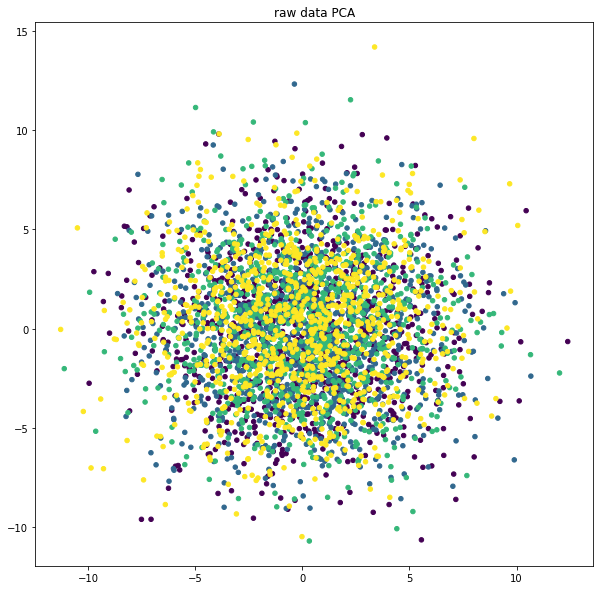

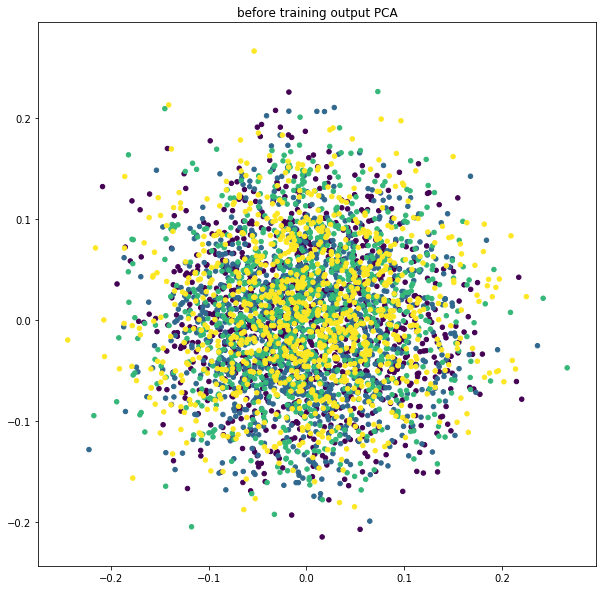

feature weight distribution: before training
layer0: 0.04192877188324928, [0.013583315536379814, 0.02834545262157917]
overall: 0.04192876589310503, [0.013583314802653847, 0.02834545109045118]


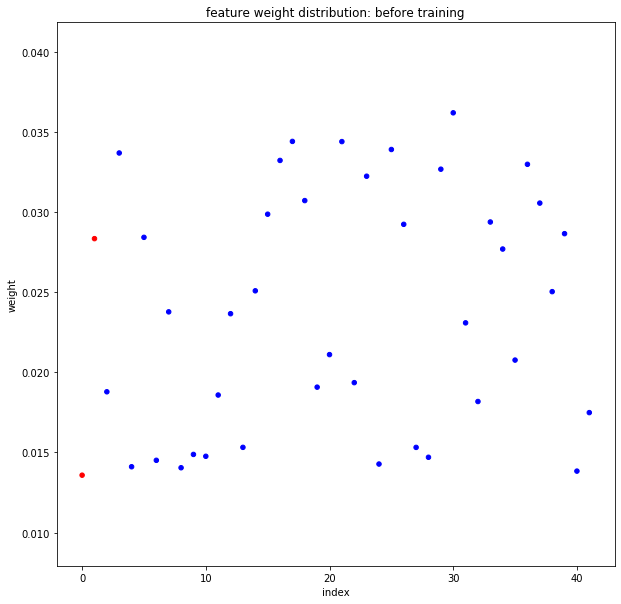

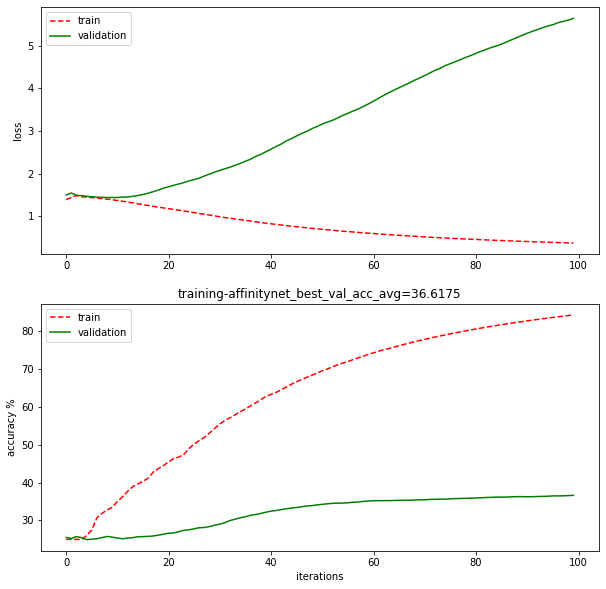

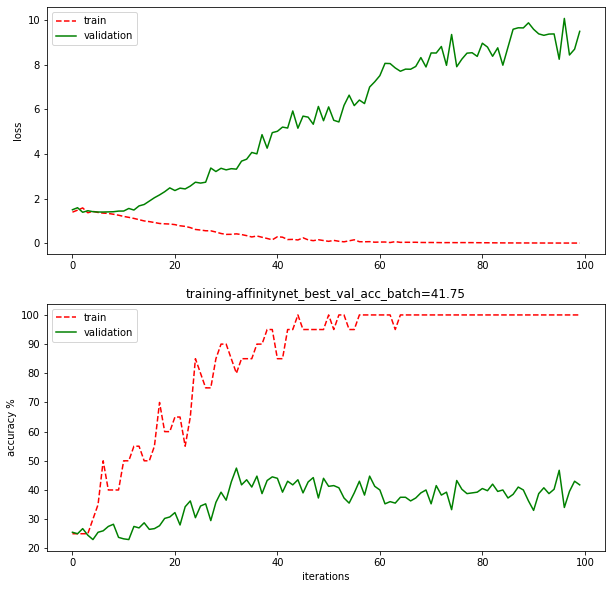

Feature weights after training
layer0: 0.17928610742092133, [0.016074439510703087, 0.16321168839931488]
overall: 0.17928611457303315, [0.016074438314935414, 0.16321167625809774]


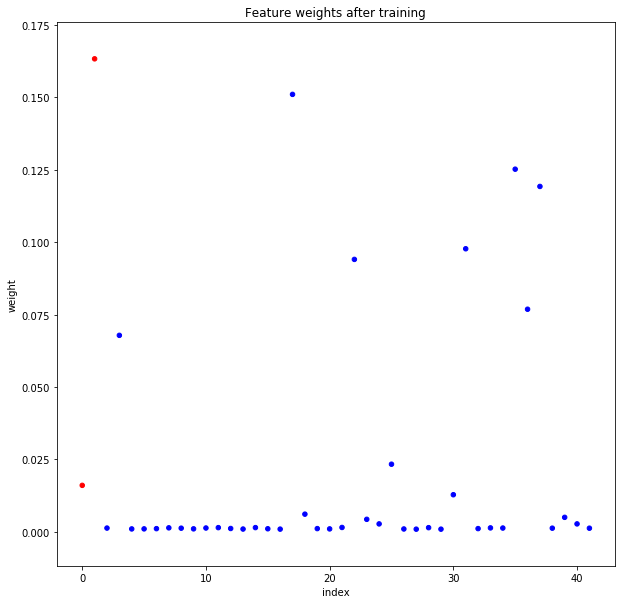

0.layers.0.components.0.a 42
1.layers.linear0.weight 4200
1.layers.linear0.bias 100
1.layers.linear1.weight 400
1.layers.linear1.bias 4
total param:4746
layers.linear0.weight 4200
layers.linear0.bias 100
layers.linear1.weight 400
layers.linear1.bias 4
total param:4704
Feature weights before training Linear
overall: 0.059268005192279816, [0.0302178505808115, 0.029050152748823166]


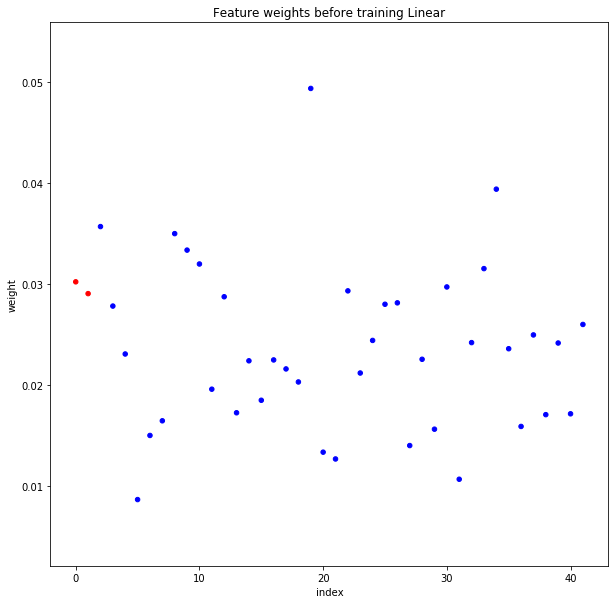

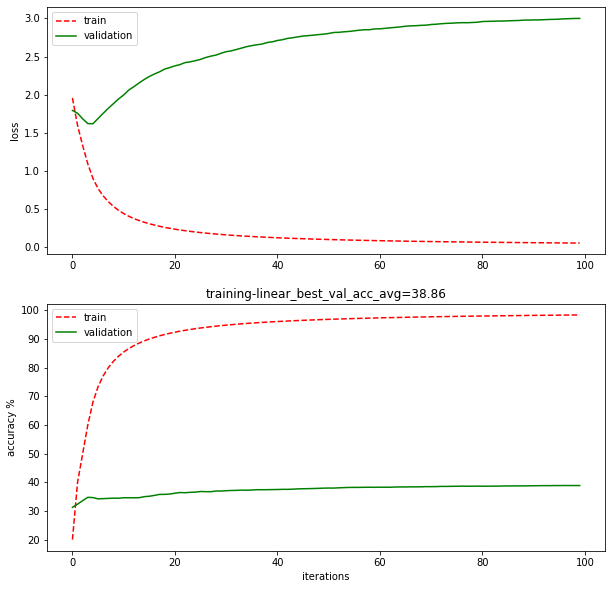

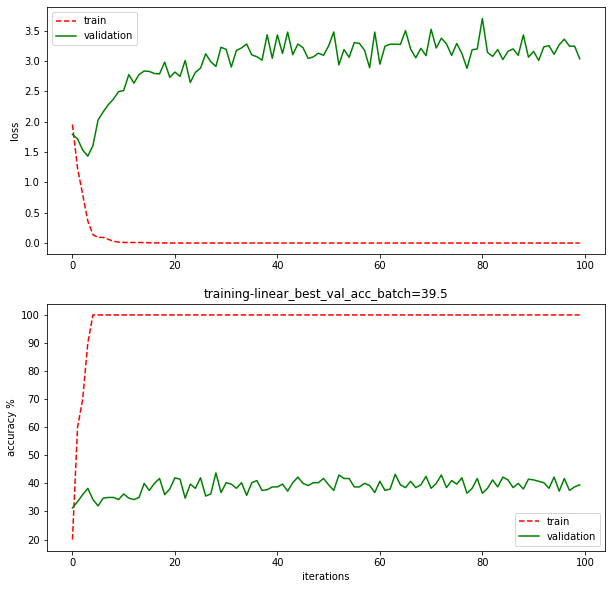

Feature weights after training Linear
overall: 0.10613632202148438, [0.06160596013069153, 0.04453035816550255]


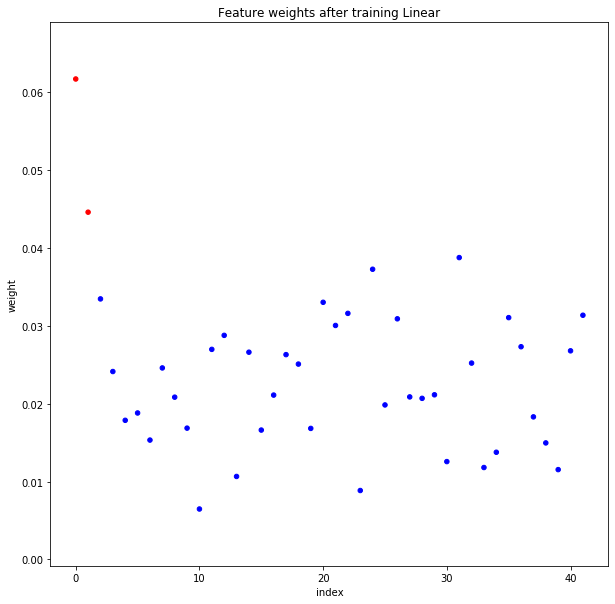

train size: 40, test size: 3960


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=0.47, nmi=0.11, f1=0.47, confusion_mat:
[[507 214 147 122]
 [214 501  38 237]
 [237  92 399 262]
 [112 289 144 445]]
Decision Tree: acc=0.99, nmi=0.95, f1=0.99, confusion_mat:
[[982   7   1   0]
 [  2 987   0   1]
 [  7   0 969  14]
 [  0  15   4 971]]
AdaBoost: acc=0.99, nmi=0.95, f1=0.99, confusion_mat:
[[982   7   1   0]
 [  3 986   0   1]
 [  7   0 967  16]
 [  0  15   3 972]]
Nearest Neighbors: acc=0.37, nmi=0.05, f1=0.35, confusion_mat:
[[702 140  67  81]
 [494 281  18 197]
 [505 132 170 183]
 [372 222  84 312]]
Linear SVM: acc=0.54, nmi=0.18, f1=0.54, confusion_mat:
[[606 153 138  93]
 [192 489  25 284]
 [177  66 526 221]
 [ 82 255 128 525]]
RBF SVM: acc=0.25, nmi=0.00, f1=0.11, confusion_mat:
[[ 14   5   0 971]
 [  5   4   2 979]
 [  4   1   3 982]
 [  0   1   3 986]]
Random Forest: acc=0.34, nmi=0.04, f1=0.33, confusion_mat:
[[361 251 275 103]
 [193 470 140 187]
 [253 301 340  96]
 [130 494 190 176]]
Naive Bayes: acc=0.89, nmi=0.75, f1=0.88, confusion_mat:
[[91

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
Decision Tree: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
AdaBoost: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
Nearest Neighbors: acc=0.62, nmi=0.36, f1=0.62, confusion_mat:
[[10  0  0  0]
 [ 4  4  0  2]
 [ 2  1  7  0]
 [ 6  0  0  4]]
Linear SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
RBF SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
Random Forest: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
Naive Bayes: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]


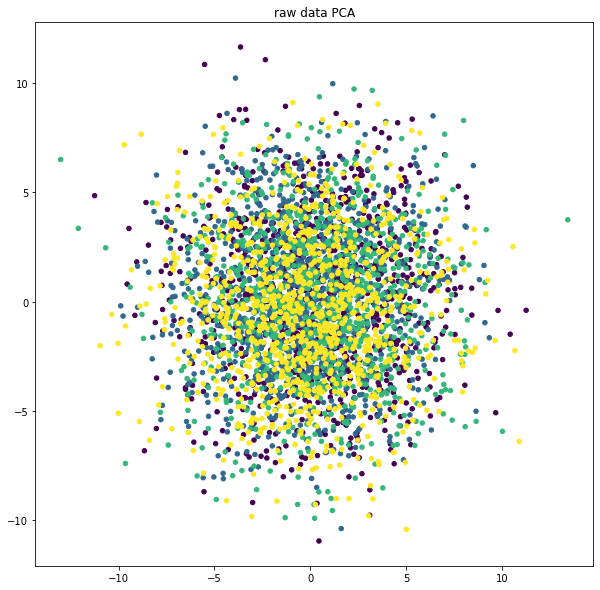

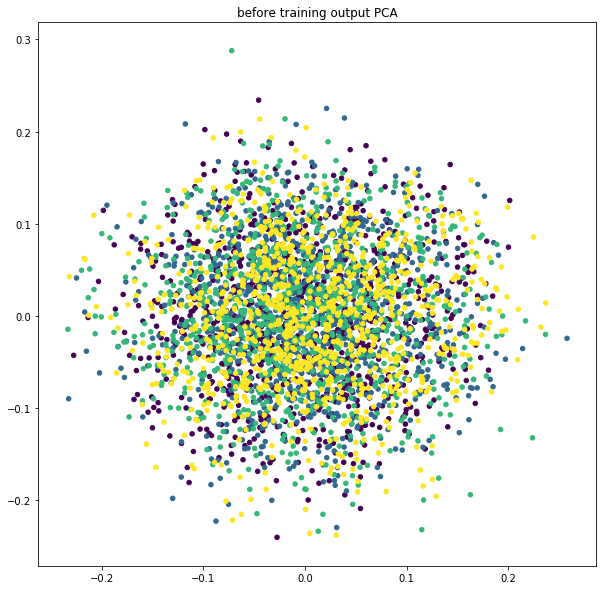

feature weight distribution: before training
layer0: 0.036153122782707214, [0.016374606639146805, 0.019778519868850708]
overall: 0.036153126103954845, [0.01637460645614632, 0.019778519647808527]


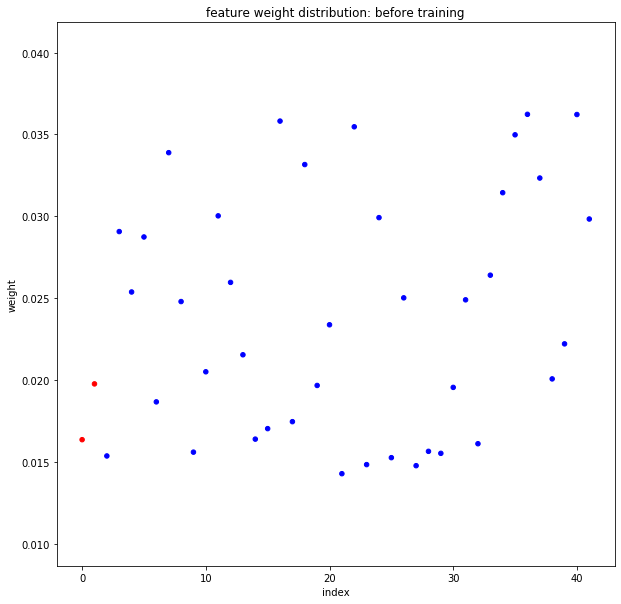

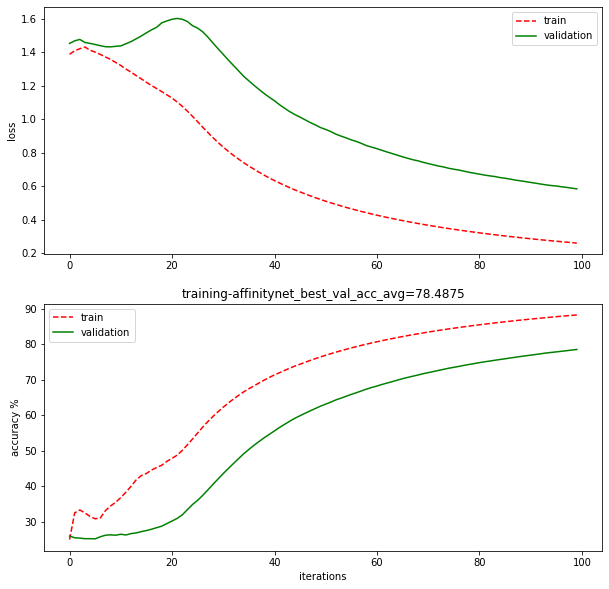

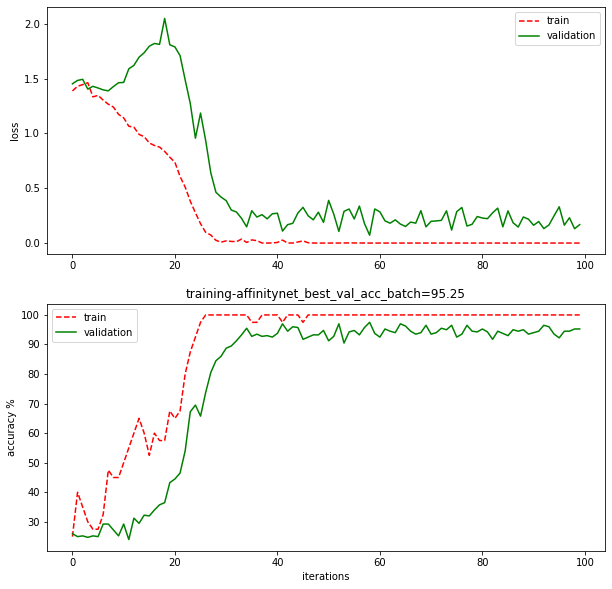

Feature weights after training
layer0: 0.36240243911743164, [0.1617739349603653, 0.20062848925590515]
overall: 0.362402424553784, [0.16177393511102903, 0.200628489442755]


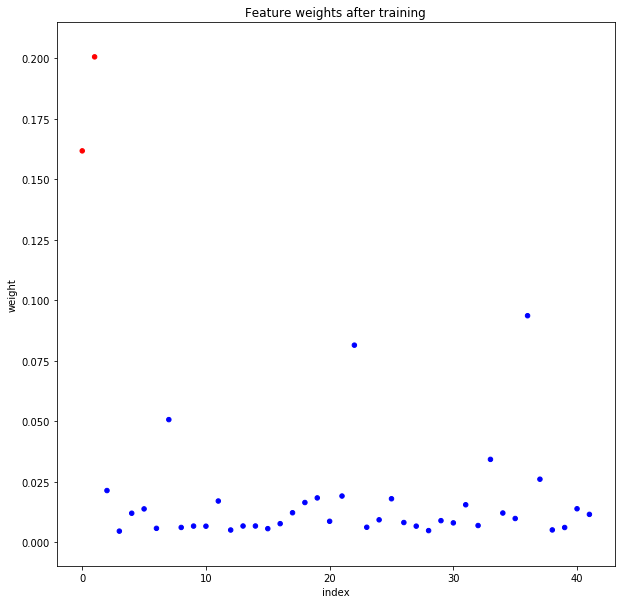

0.layers.0.components.0.a 42
1.layers.linear0.weight 4200
1.layers.linear0.bias 100
1.layers.linear1.weight 400
1.layers.linear1.bias 4
total param:4746
layers.linear0.weight 4200
layers.linear0.bias 100
layers.linear1.weight 400
layers.linear1.bias 4
total param:4704
Feature weights before training Linear
overall: 0.04248037934303284, [0.01635819301009178, 0.026122184470295906]


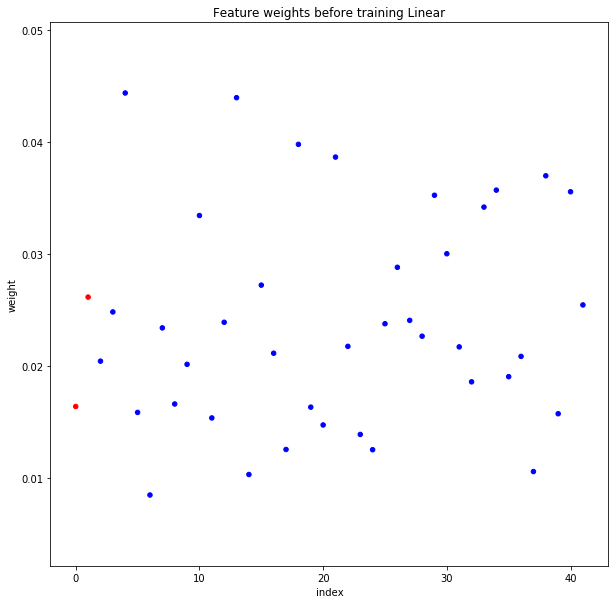

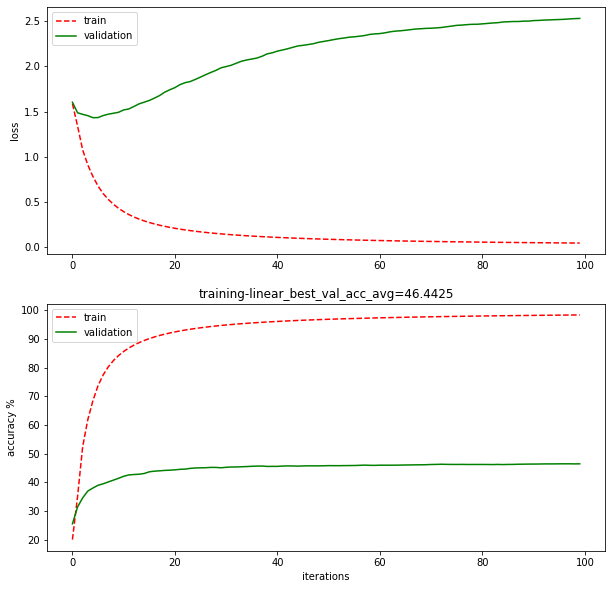

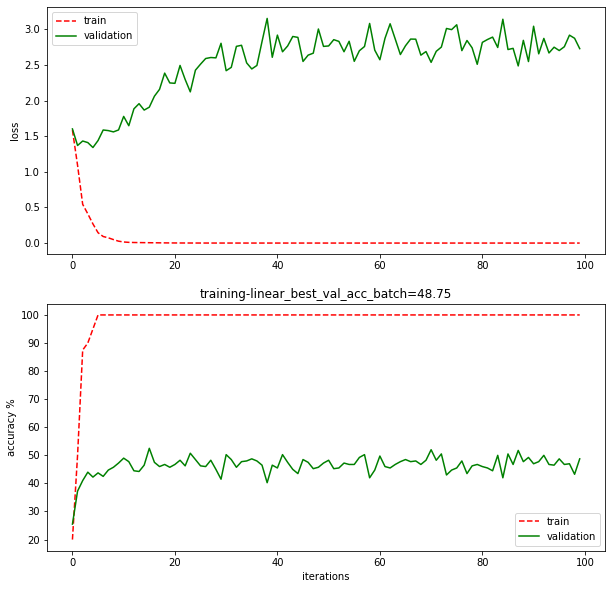

Feature weights after training Linear
overall: 0.13806697726249695, [0.06748947501182556, 0.07057750225067139]


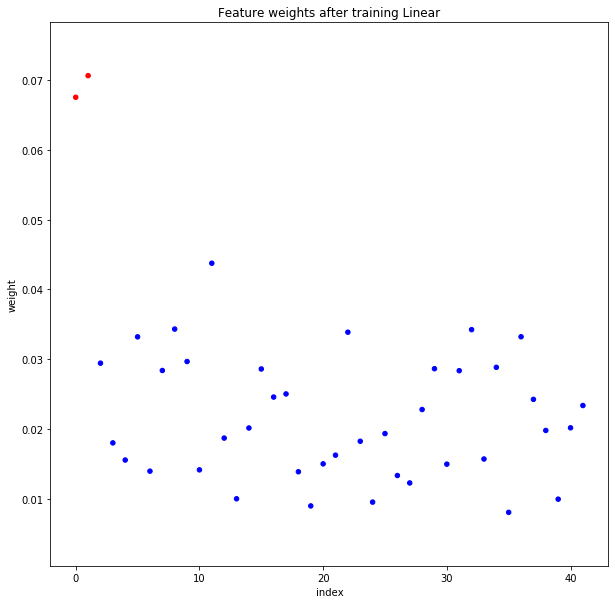

train size: 400, test size: 3600


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=0.92, nmi=0.76, f1=0.92, confusion_mat:
[[802  38  55   5]
 [ 43 828   2  27]
 [ 15   0 852  33]
 [  2  30  35 833]]
Decision Tree: acc=0.98, nmi=0.94, f1=0.98, confusion_mat:
[[892   5   3   0]
 [  4 891   0   5]
 [  2   0 881  17]
 [  0   8  12 880]]
AdaBoost: acc=0.50, nmi=0.64, f1=0.33, confusion_mat:
[[897   0   3   0]
 [895   0   5   0]
 [  2   0 898   0]
 [  8   0 892   0]]
Nearest Neighbors: acc=0.45, nmi=0.09, f1=0.44, confusion_mat:
[[520 223 123  34]
 [299 469  37  95]
 [324 152 322 102]
 [190 297 114 299]]
Linear SVM: acc=0.94, nmi=0.81, f1=0.94, confusion_mat:
[[836  31  31   2]
 [ 28 852   0  20]
 [ 23   0 845  32]
 [  0  31  14 855]]
RBF SVM: acc=0.29, nmi=0.03, f1=0.21, confusion_mat:
[[ 72  46  20 762]
 [ 35  88   8 769]
 [ 21  18  76 785]
 [  9  38  37 816]]
Random Forest: acc=0.55, nmi=0.21, f1=0.55, confusion_mat:
[[542 122 166  70]
 [ 78 556  47 219]
 [252  47 427 174]
 [ 28 262 145 465]]
Naive Bayes: acc=0.99, nmi=0.94, f1=0.99, confusion_mat:
[[88

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]
Decision Tree: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]
AdaBoost: acc=0.50, nmi=0.67, f1=0.33, confusion_mat:
[[100   0   0   0]
 [100   0   0   0]
 [  0   0 100   0]
 [  0   0 100   0]]
Nearest Neighbors: acc=0.68, nmi=0.35, f1=0.67, confusion_mat:
[[88  5  7  0]
 [24 72  1  3]
 [19 10 64  7]
 [18 29  6 47]]
Linear SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]
RBF SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]
Random Forest: acc=0.84, nmi=0.59, f1=0.84, confusion_mat:
[[84  4 10  2]
 [ 3 82  1 14]
 [12  0 82  6]
 [ 2  6  4 88]]
Naive Bayes: acc=0.99, nmi=0.96, f1=0.99, confusion_mat:
[[ 99   0   1   0]
 [  0  99   0   1

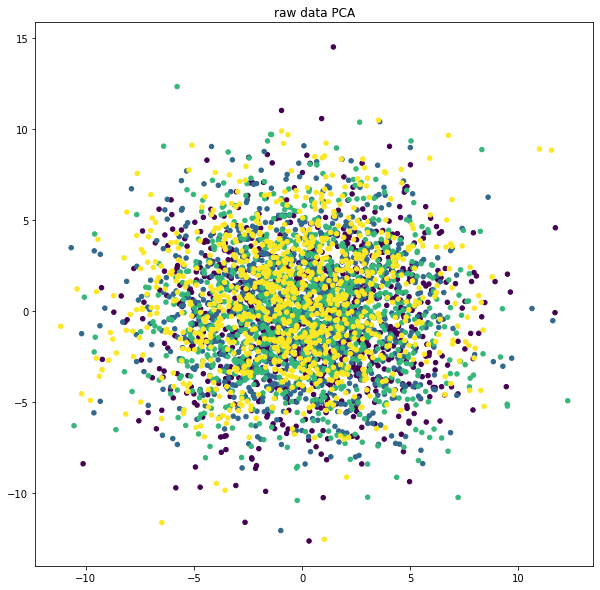

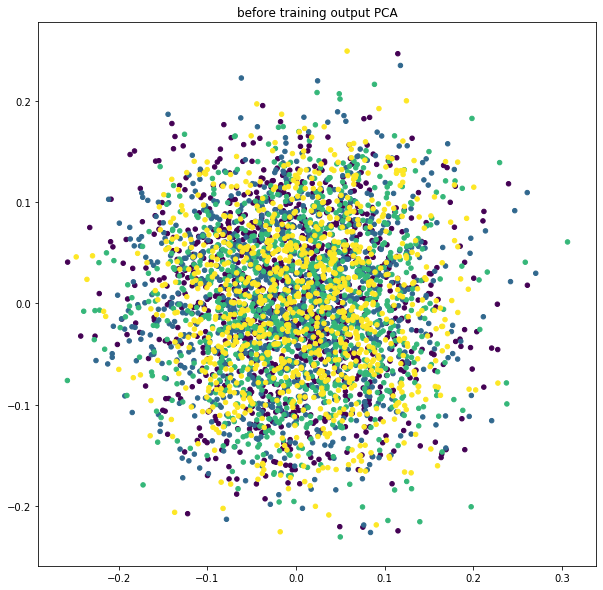

feature weight distribution: before training
layer0: 0.04002831503748894, [0.017807647585868835, 0.0222206711769104]
overall: 0.040028315034851894, [0.017807645927402572, 0.022220669107449326]


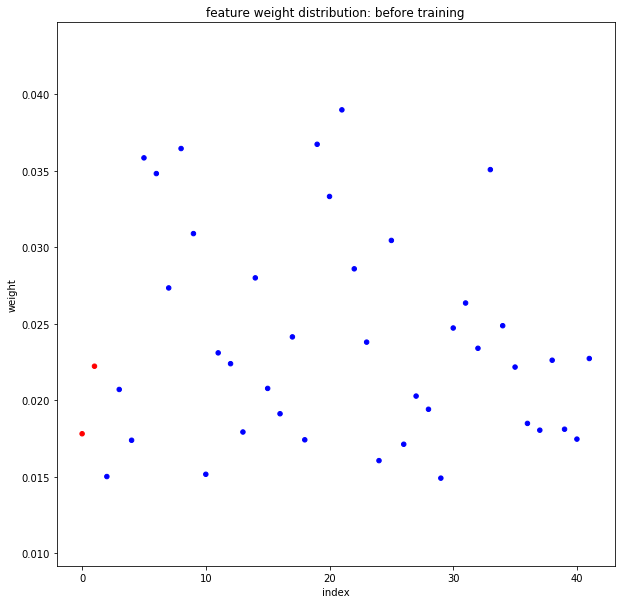

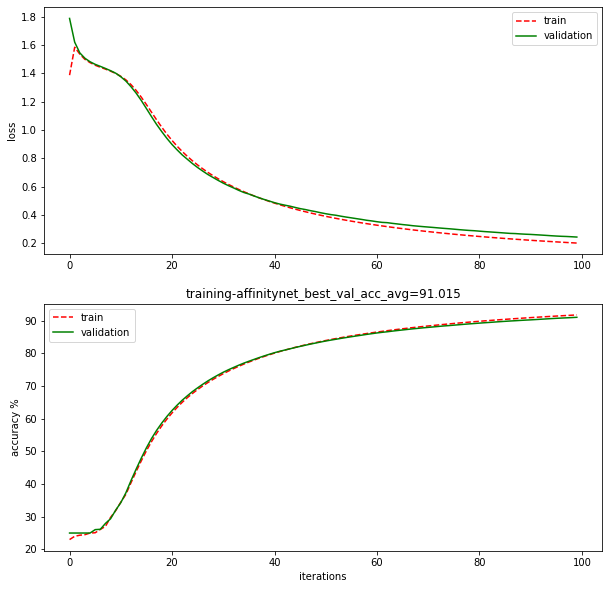

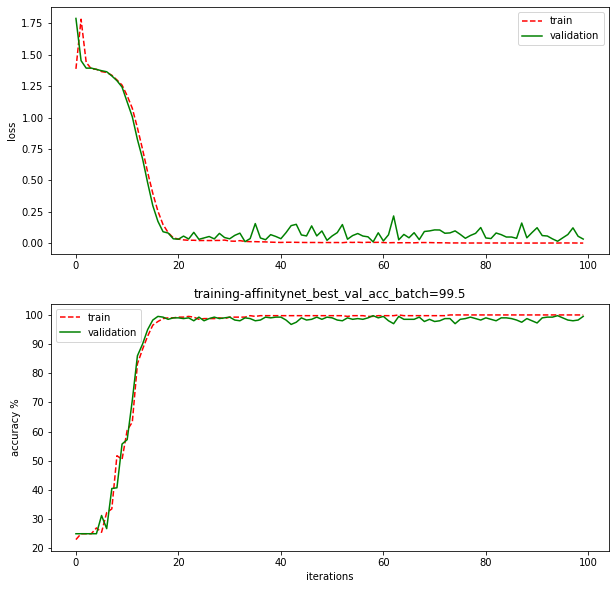

Feature weights after training
layer0: 0.4632336497306824, [0.24011792242527008, 0.2231157124042511]
overall: 0.463233636123781, [0.24011792309615182, 0.2231157130276292]


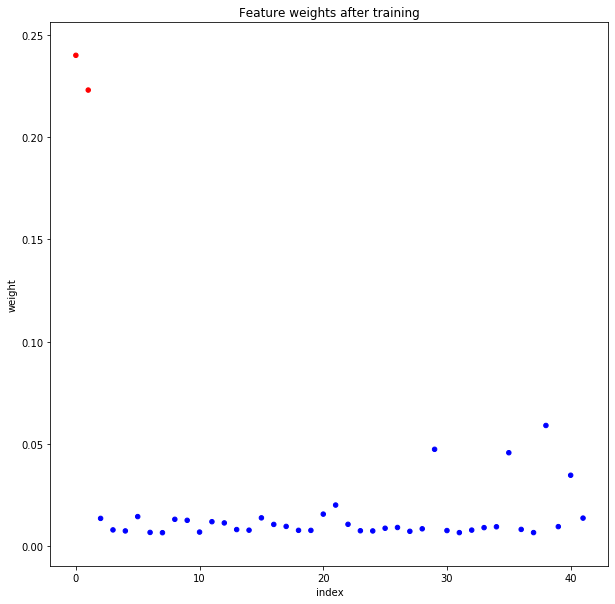

0.layers.0.components.0.a 42
1.layers.linear0.weight 4200
1.layers.linear0.bias 100
1.layers.linear1.weight 400
1.layers.linear1.bias 4
total param:4746
layers.linear0.weight 4200
layers.linear0.bias 100
layers.linear1.weight 400
layers.linear1.bias 4
total param:4704
Feature weights before training Linear
overall: 0.05938093364238739, [0.03613823652267456, 0.02324269525706768]


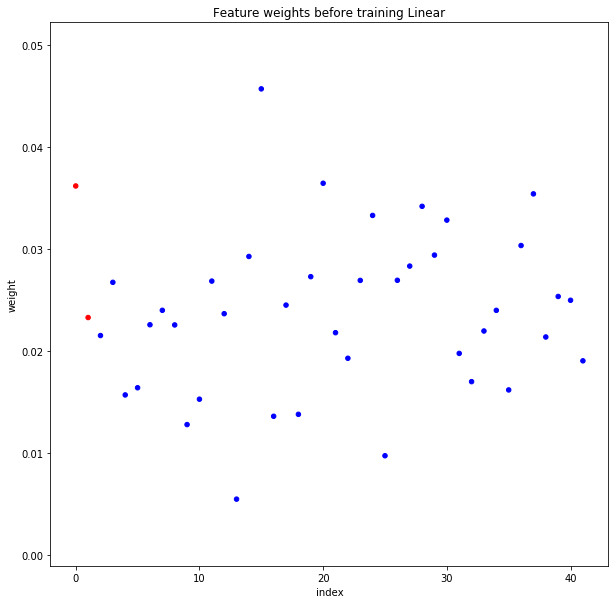

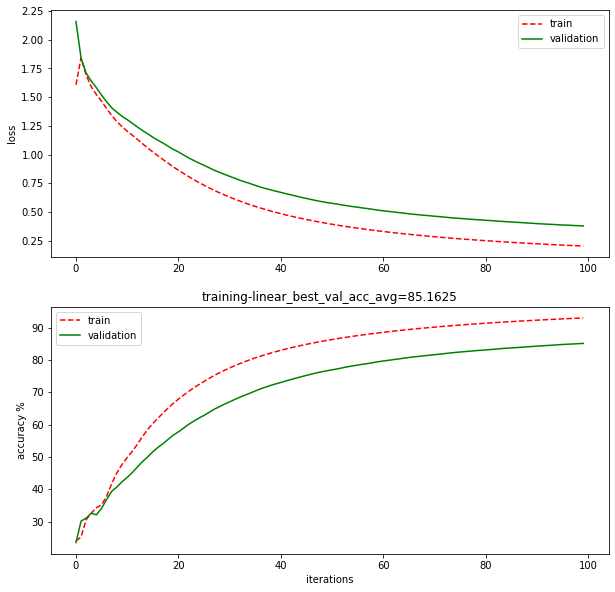

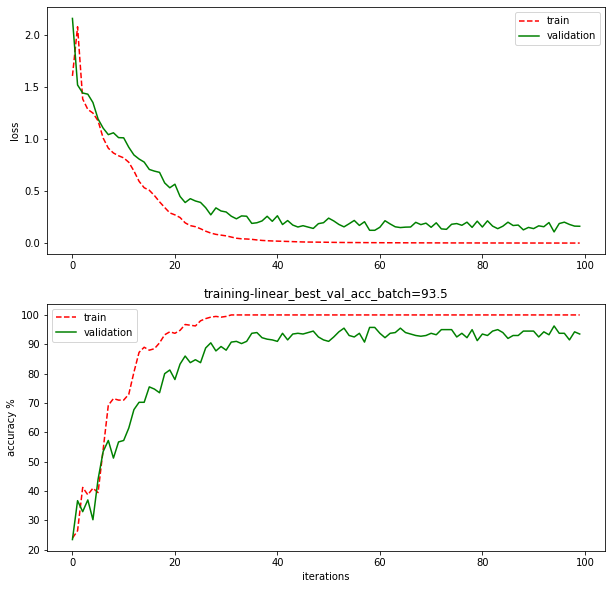

Feature weights after training Linear
overall: 0.4869498610496521, [0.2330074906349182, 0.2539423704147339]


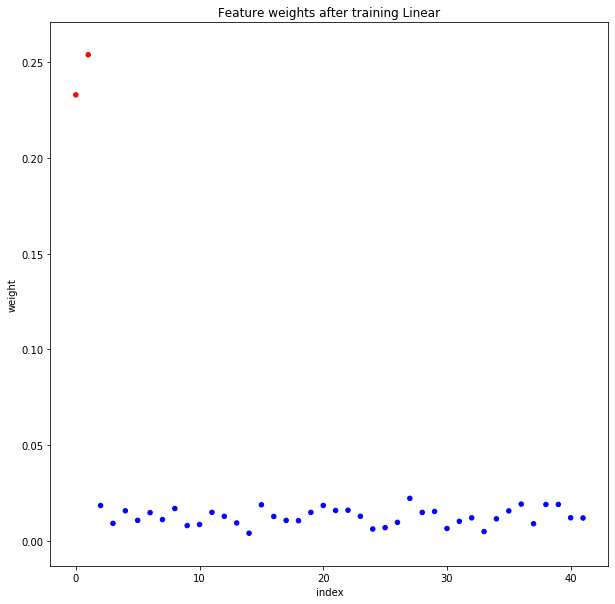

train size: 800, test size: 3200


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=0.96, nmi=0.87, f1=0.96, confusion_mat:
[[776  14   8   2]
 [ 19 766   0  15]
 [ 10   0 763  27]
 [  0  10  12 778]]
Decision Tree: acc=0.98, nmi=0.93, f1=0.98, confusion_mat:
[[796   2   2   0]
 [ 14 770   0  16]
 [ 15   0 782   3]
 [  0   4   3 793]]
AdaBoost: acc=0.98, nmi=0.93, f1=0.98, confusion_mat:
[[785   3  12   0]
 [  5 790   0   5]
 [  2   0 773  25]
 [  0   6   0 794]]
Nearest Neighbors: acc=0.47, nmi=0.12, f1=0.47, confusion_mat:
[[477 173 120  30]
 [258 434  26  82]
 [278 103 345  74]
 [153 265 124 258]]
Linear SVM: acc=0.97, nmi=0.87, f1=0.97, confusion_mat:
[[774  12  14   0]
 [ 12 780   0   8]
 [ 16   1 766  17]
 [  0  18  12 770]]
RBF SVM: acc=0.32, nmi=0.04, f1=0.27, confusion_mat:
[[ 97  64  43 596]
 [ 48 126  14 612]
 [ 44  18 112 626]
 [ 17  50  51 682]]
Random Forest: acc=0.65, nmi=0.39, f1=0.65, confusion_mat:
[[631 134  24  11]
 [313 417  15  55]
 [ 48  21 411 320]
 [ 11  50 108 631]]
Naive Bayes: acc=0.99, nmi=0.95, f1=0.99, confusion_mat:
[[79

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[200   0   0   0]
 [  0 200   0   0]
 [  0   0 200   0]
 [  0   0   0 200]]
Decision Tree: acc=1.00, nmi=0.99, f1=1.00, confusion_mat:
[[200   0   0   0]
 [  0 200   0   0]
 [  0   0 200   0]
 [  0   0   1 199]]
AdaBoost: acc=0.99, nmi=0.96, f1=0.99, confusion_mat:
[[198   1   1   0]
 [  0 200   0   0]
 [  0   0 195   5]
 [  0   2   0 198]]
Nearest Neighbors: acc=0.74, nmi=0.41, f1=0.74, confusion_mat:
[[170  16  12   2]
 [ 35 156   1   8]
 [ 33  16 142   9]
 [ 22  41  14 123]]
Linear SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[200   0   0   0]
 [  0 200   0   0]
 [  0   0 200   0]
 [  0   0   0 200]]
RBF SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[200   0   0   0]
 [  0 200   0   0]
 [  0   0 200   0]
 [  0   0   0 200]]
Random Forest: acc=0.82, nmi=0.61, f1=0.82, confusion_mat:
[[172  25   3   0]
 [ 37 160   0   3]
 [  5   0 163  32]
 [  2   4  34 160]]
Naive Bayes: acc=0.99, nmi=0.97, f1=0.99, confusion_mat:
[[19

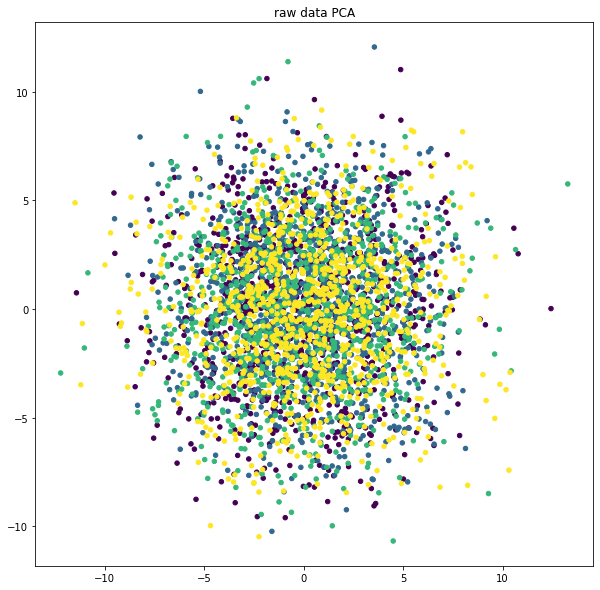

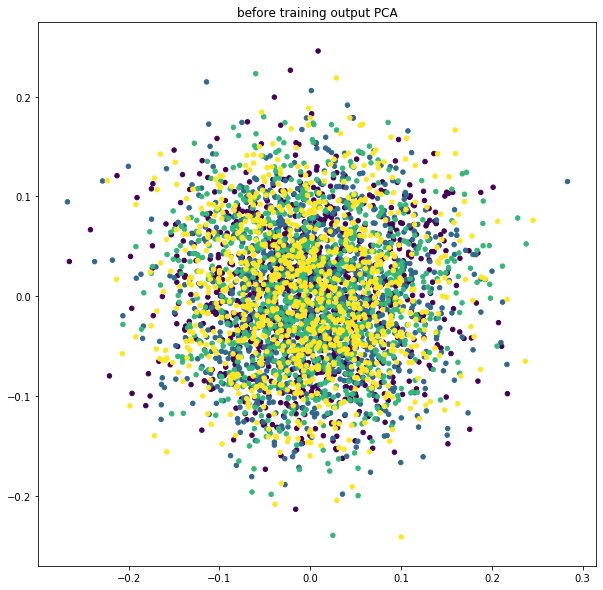

feature weight distribution: before training
layer0: 0.03339119255542755, [0.01605001837015152, 0.01734117791056633]
overall: 0.033391193606292224, [0.016050017084645603, 0.01734117652164662]


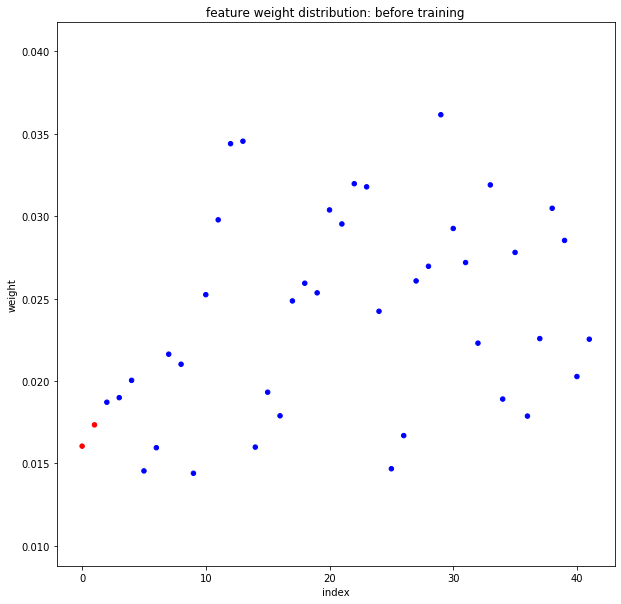

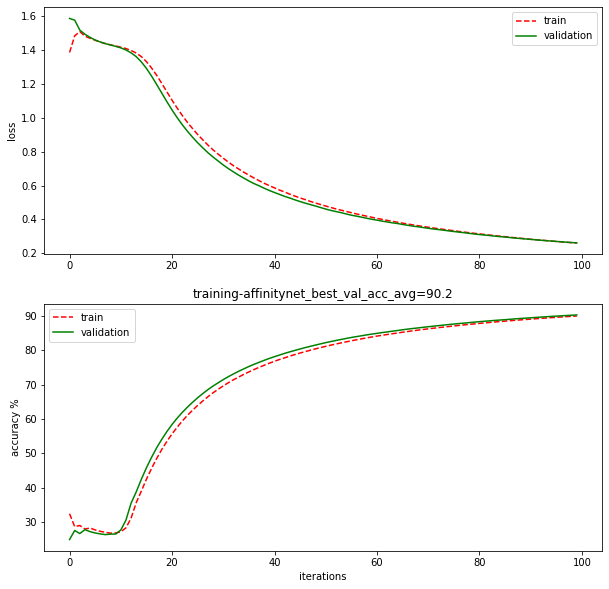

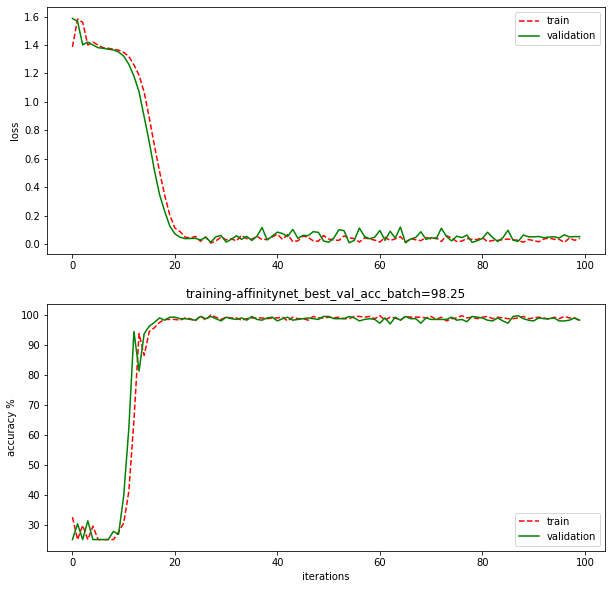

Feature weights after training
layer0: 0.5294914841651917, [0.27148497104644775, 0.2580065131187439]
overall: 0.5294914683851162, [0.27148496295556535, 0.25800650542955084]


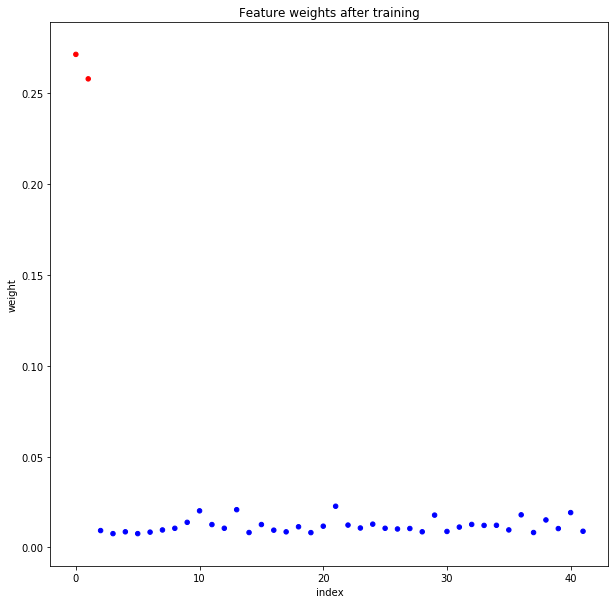

0.layers.0.components.0.a 42
1.layers.linear0.weight 4200
1.layers.linear0.bias 100
1.layers.linear1.weight 400
1.layers.linear1.bias 4
total param:4746
layers.linear0.weight 4200
layers.linear0.bias 100
layers.linear1.weight 400
layers.linear1.bias 4
total param:4704
Feature weights before training Linear
overall: 0.04458140209317207, [0.019923387095332146, 0.024658014997839928]


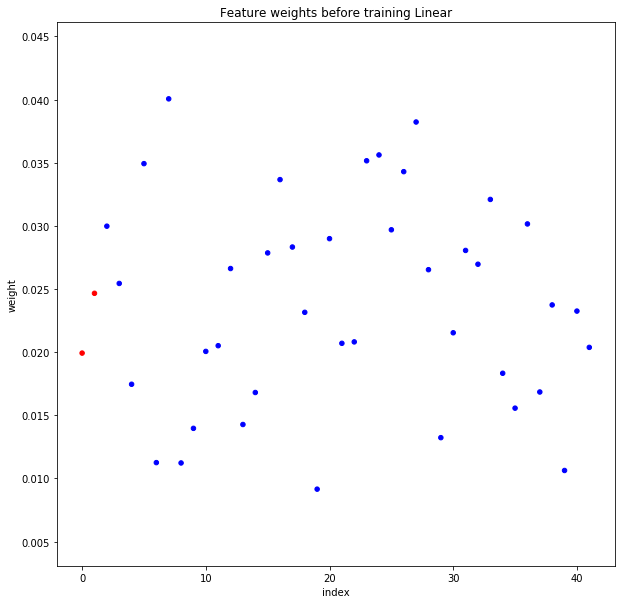

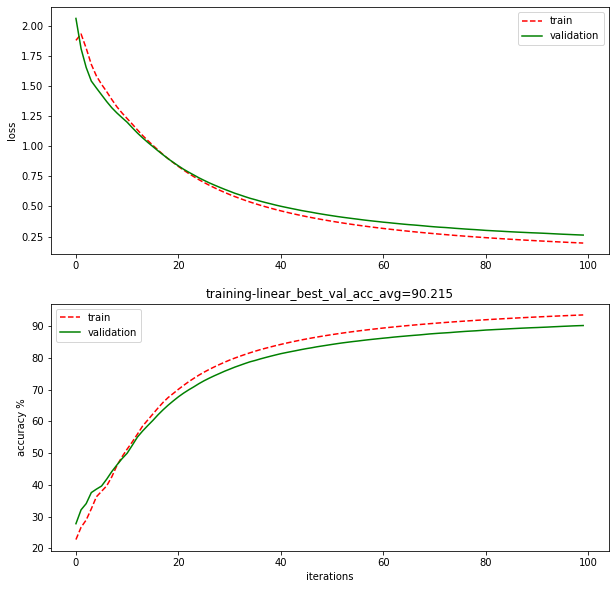

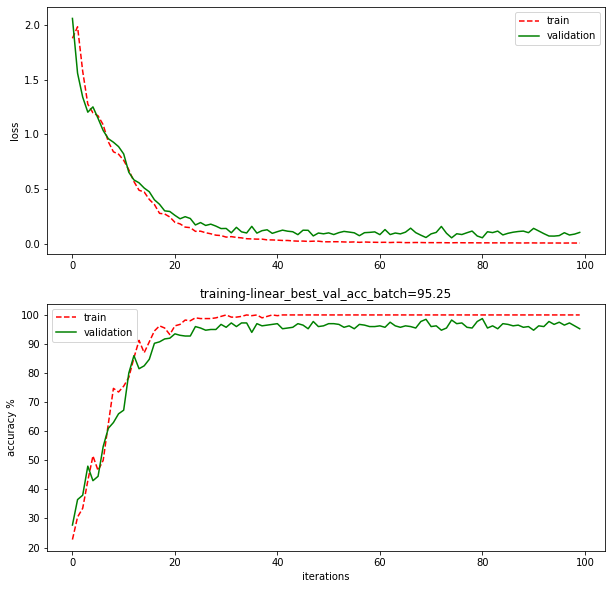

Feature weights after training Linear
overall: 0.5858924388885498, [0.3066214919090271, 0.2792709767818451]


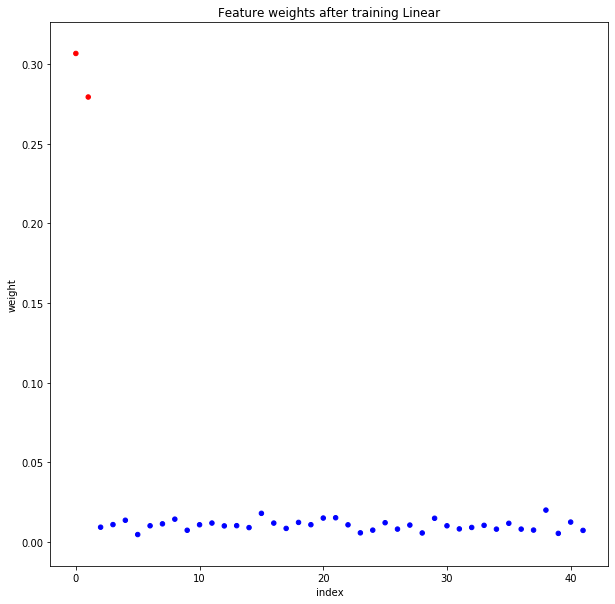

train size: 2000, test size: 2000


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=0.98, nmi=0.93, f1=0.98, confusion_mat:
[[489   6   5   0]
 [  7 490   0   3]
 [  2   0 493   5]
 [  0   2   4 494]]
Decision Tree: acc=0.98, nmi=0.94, f1=0.99, confusion_mat:
[[493   5   2   0]
 [  3 492   0   5]
 [  7   0 491   2]
 [  0   3   3 494]]
AdaBoost: acc=0.97, nmi=0.91, f1=0.97, confusion_mat:
[[494   4   2   0]
 [ 14 466   0  20]
 [  2   0 494   4]
 [  0   1   3 496]]
Nearest Neighbors: acc=0.51, nmi=0.15, f1=0.51, confusion_mat:
[[326  94  54  26]
 [175 243  14  68]
 [152  47 235  66]
 [ 80 132  72 216]]
Linear SVM: acc=0.97, nmi=0.89, f1=0.97, confusion_mat:
[[489   6   5   0]
 [  6 489   0   5]
 [ 14   0 478   8]
 [  0   7   8 485]]
RBF SVM: acc=0.37, nmi=0.07, f1=0.34, confusion_mat:
[[113  51  31 305]
 [ 50 103  11 336]
 [ 32  16 116 336]
 [  8  38  45 409]]
Random Forest: acc=0.61, nmi=0.42, f1=0.61, confusion_mat:
[[276 214   9   1]
 [148 336  11   5]
 [  8  11 321 160]
 [  7  14 191 288]]
Naive Bayes: acc=0.99, nmi=0.95, f1=0.99, confusion_mat:
[[49

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[500   0   0   0]
 [  0 500   0   0]
 [  0   0 500   0]
 [  0   0   0 500]]
Decision Tree: acc=1.00, nmi=0.99, f1=1.00, confusion_mat:
[[499   1   0   0]
 [  0 500   0   0]
 [  0   0 500   0]
 [  0   2   2 496]]
AdaBoost: acc=0.99, nmi=0.98, f1=0.99, confusion_mat:
[[499   1   0   0]
 [  1 491   0   8]
 [  0   0 500   0]
 [  0   0   1 499]]
Nearest Neighbors: acc=0.76, nmi=0.45, f1=0.76, confusion_mat:
[[441  30  26   3]
 [100 366   7  27]
 [ 85  33 355  27]
 [ 42  69  30 359]]
Linear SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[500   0   0   0]
 [  0 500   0   0]
 [  0   0 500   0]
 [  0   0   0 500]]
RBF SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[500   0   0   0]
 [  0 500   0   0]
 [  0   0 500   0]
 [  0   0   0 500]]
Random Forest: acc=0.68, nmi=0.46, f1=0.68, confusion_mat:
[[359 120  15   6]
 [142 342   8   8]
 [  5   7 344 144]
 [  1  18 167 314]]
Naive Bayes: acc=0.99, nmi=0.97, f1=0.99, confusion_mat:
[[49

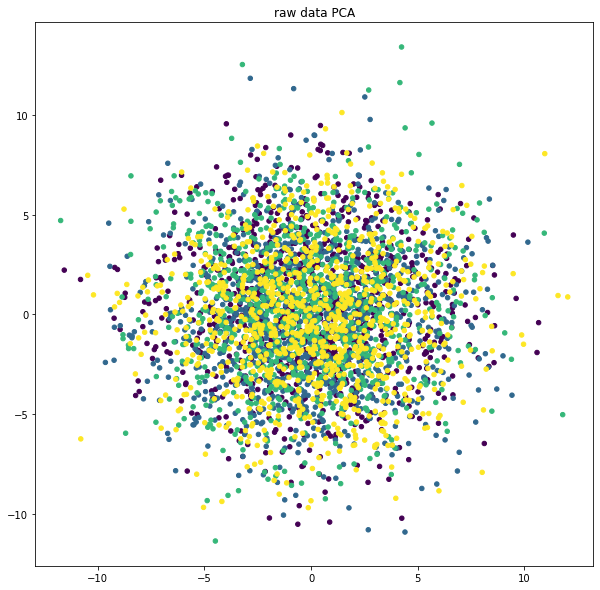

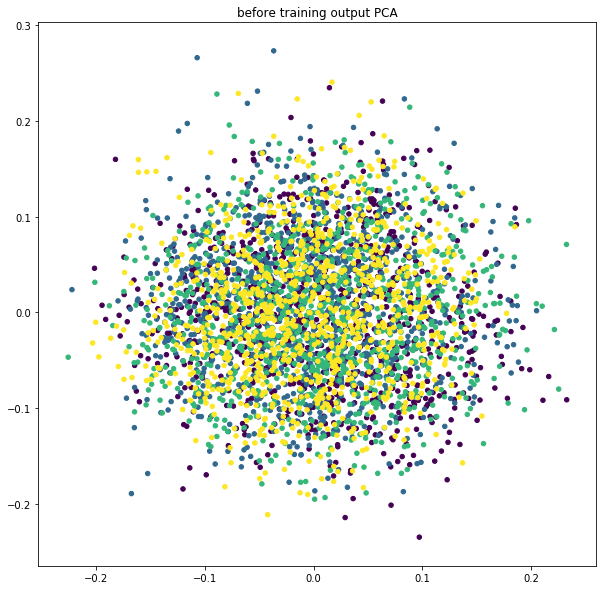

feature weight distribution: before training
layer0: 0.04726335406303406, [0.03263948857784271, 0.014623865485191345]
overall: 0.047263355471591814, [0.0326394895505753, 0.014623865921016511]


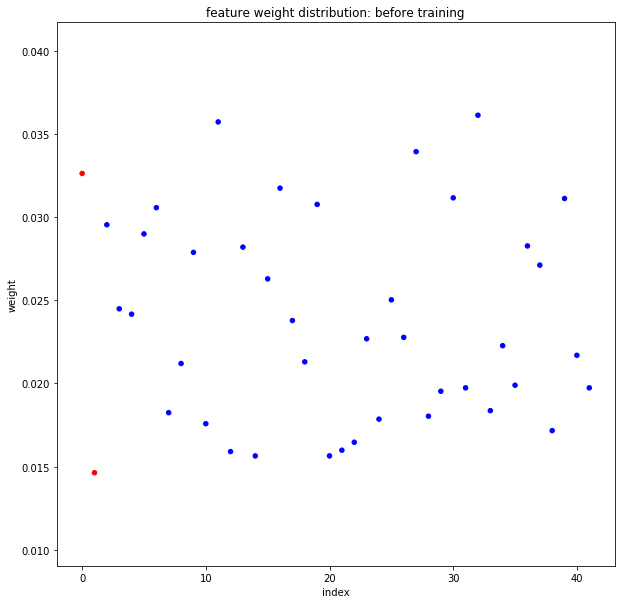

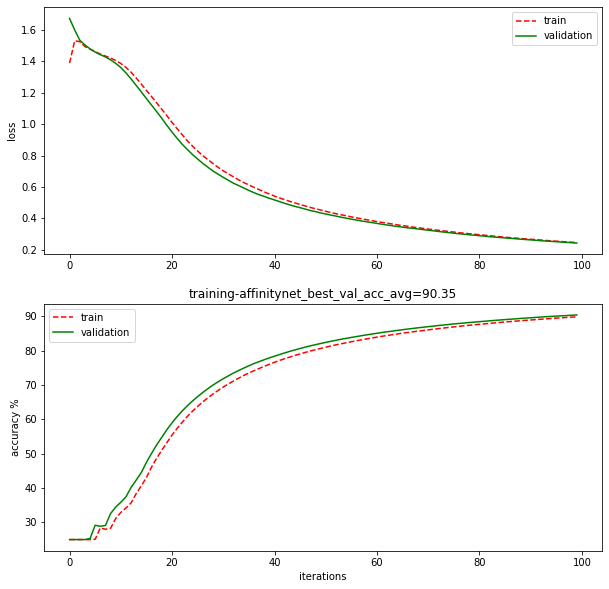

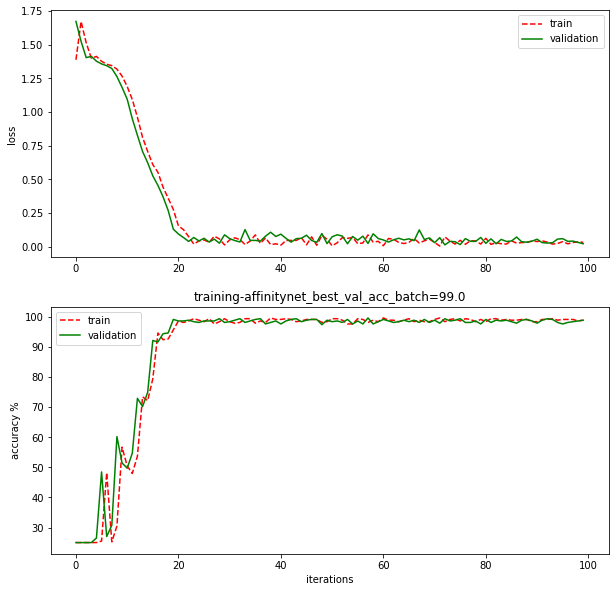

Feature weights after training
layer0: 0.5169036388397217, [0.22540058195590973, 0.29150307178497314]
overall: 0.5169036311148939, [0.2254005720896396, 0.2915030590252543]


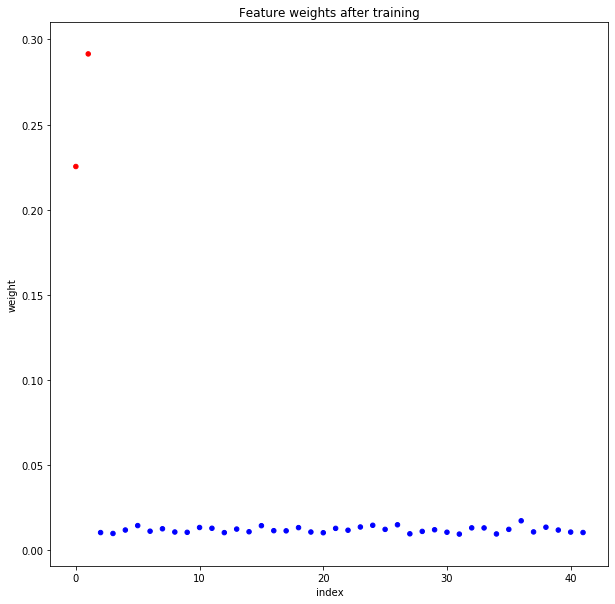

0.layers.0.components.0.a 42
1.layers.linear0.weight 4200
1.layers.linear0.bias 100
1.layers.linear1.weight 400
1.layers.linear1.bias 4
total param:4746
layers.linear0.weight 4200
layers.linear0.bias 100
layers.linear1.weight 400
layers.linear1.bias 4
total param:4704
Feature weights before training Linear
overall: 0.04051397368311882, [0.02502455934882164, 0.01548941433429718]


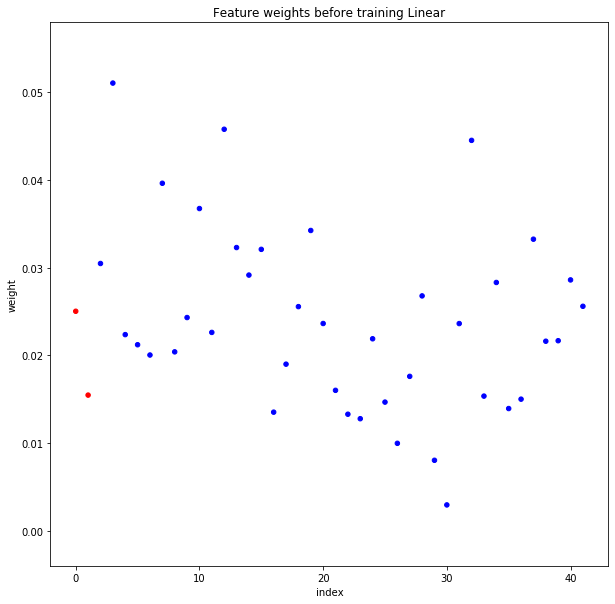

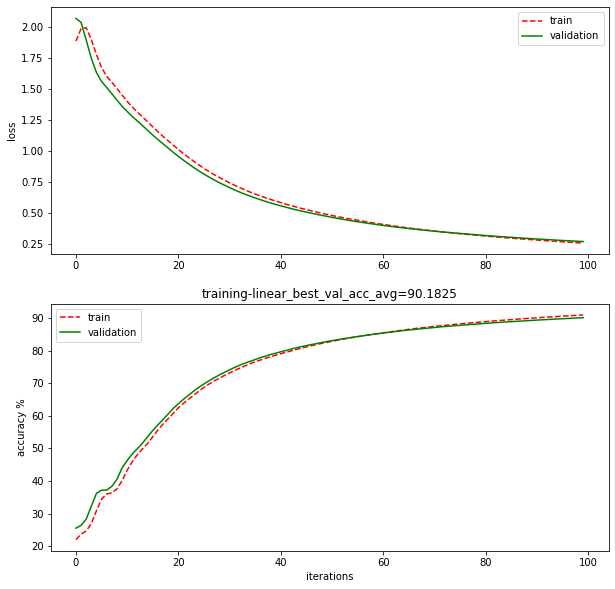

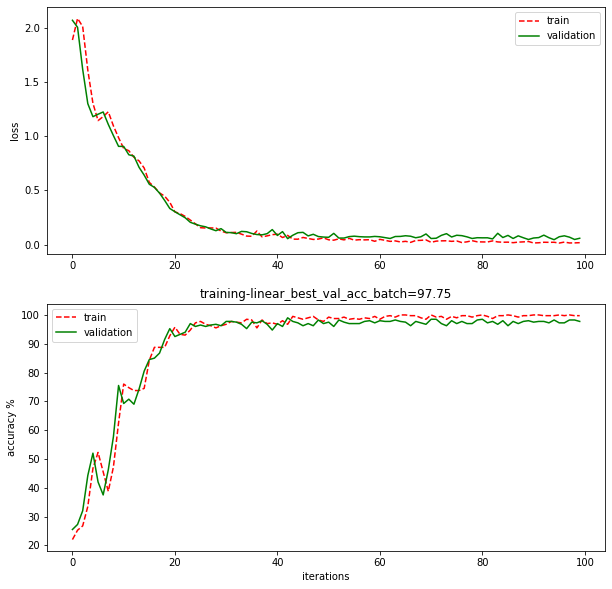

Feature weights after training Linear
overall: 0.6161501407623291, [0.31045034527778625, 0.30569982528686523]


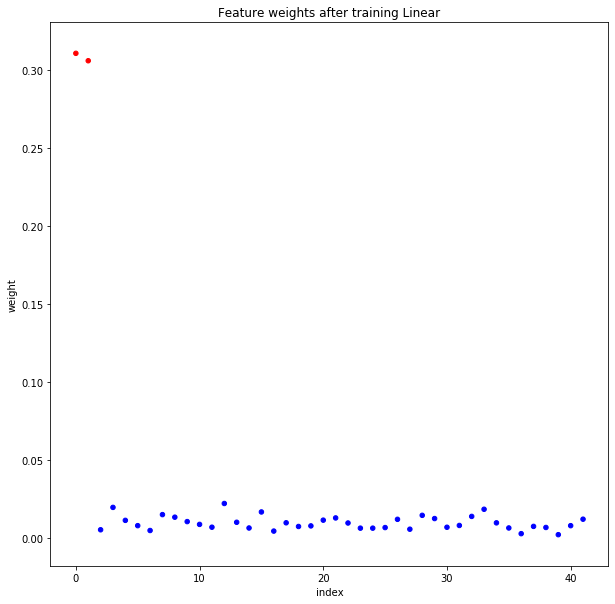

train size: 3200, test size: 800


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=0.98, nmi=0.93, f1=0.98, confusion_mat:
[[196   3   1   0]
 [  1 197   0   2]
 [  1   0 196   3]
 [  0   3   0 197]]
Decision Tree: acc=0.98, nmi=0.93, f1=0.98, confusion_mat:
[[197   2   1   0]
 [  0 197   0   3]
 [  0   0 197   3]
 [  0   5   0 195]]
AdaBoost: acc=0.97, nmi=0.90, f1=0.97, confusion_mat:
[[188  11   1   0]
 [  0 196   0   4]
 [  3   0 196   1]
 [  0   3   0 197]]
Nearest Neighbors: acc=0.52, nmi=0.17, f1=0.52, confusion_mat:
[[124  43  23  10]
 [ 70 108   2  20]
 [ 54  16 104  26]
 [ 30  61  29  80]]
Linear SVM: acc=0.97, nmi=0.90, f1=0.97, confusion_mat:
[[197   3   0   0]
 [  4 194   0   2]
 [  2   0 197   1]
 [  0   6   3 191]]
RBF SVM: acc=0.36, nmi=0.05, f1=0.35, confusion_mat:
[[ 47  26  20 107]
 [ 19  50  11 120]
 [ 16   9  46 129]
 [  7  21  23 149]]
Random Forest: acc=0.92, nmi=0.76, f1=0.92, confusion_mat:
[[190   6   4   0]
 [  9 176   2  13]
 [  0   0 196   4]
 [  0  15  14 171]]
Naive Bayes: acc=0.99, nmi=0.95, f1=0.99, confusion_mat:
[[19

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[800   0   0   0]
 [  0 800   0   0]
 [  0   0 800   0]
 [  0   1   0 799]]
Decision Tree: acc=1.00, nmi=0.98, f1=1.00, confusion_mat:
[[796   1   3   0]
 [  1 798   0   1]
 [  0   0 795   5]
 [  0   3   0 797]]
AdaBoost: acc=0.98, nmi=0.93, f1=0.98, confusion_mat:
[[764  33   3   0]
 [  4 792   0   4]
 [  6   0 792   2]
 [  0   4   4 792]]
Nearest Neighbors: acc=0.77, nmi=0.47, f1=0.77, confusion_mat:
[[727  33  36   4]
 [149 594  14  43]
 [134  37 591  38]
 [ 70 124  51 555]]
Linear SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[800   0   0   0]
 [  0 800   0   0]
 [  0   0 800   0]
 [  0   0   0 800]]
RBF SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[800   0   0   0]
 [  0 800   0   0]
 [  0   0 800   0]
 [  0   0   0 800]]
Random Forest: acc=0.56, nmi=0.23, f1=0.56, confusion_mat:
[[541  81 129  49]
 [ 69 492  41 198]
 [317  72 345  66]
 [ 68 267  40 425]]
Naive Bayes: acc=0.99, nmi=0.96, f1=0.99, confusion_mat:
[[79

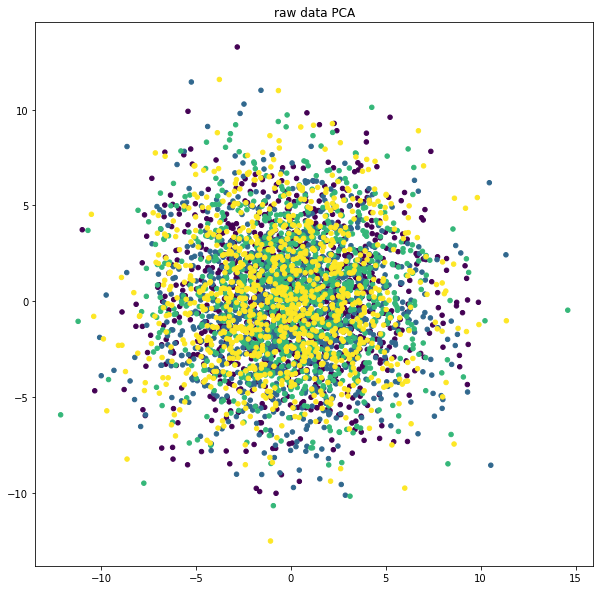

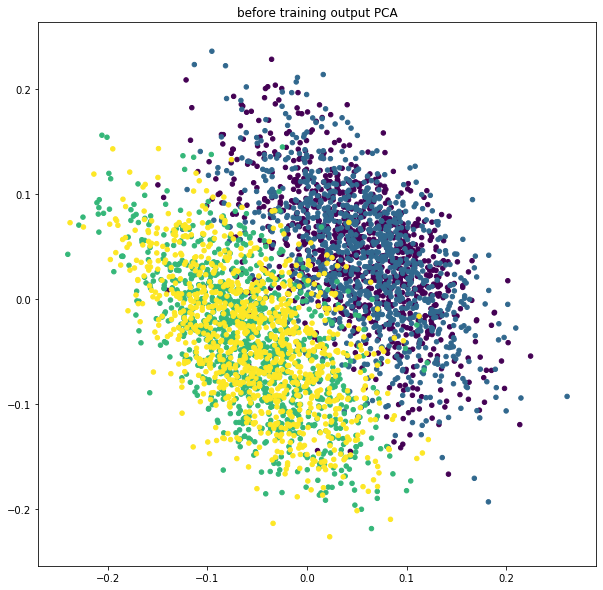

feature weight distribution: before training
layer0: 0.058135487139225006, [0.02081877365708351, 0.037316709756851196]
overall: 0.05813548411779226, [0.020818773909140435, 0.03731671020865183]


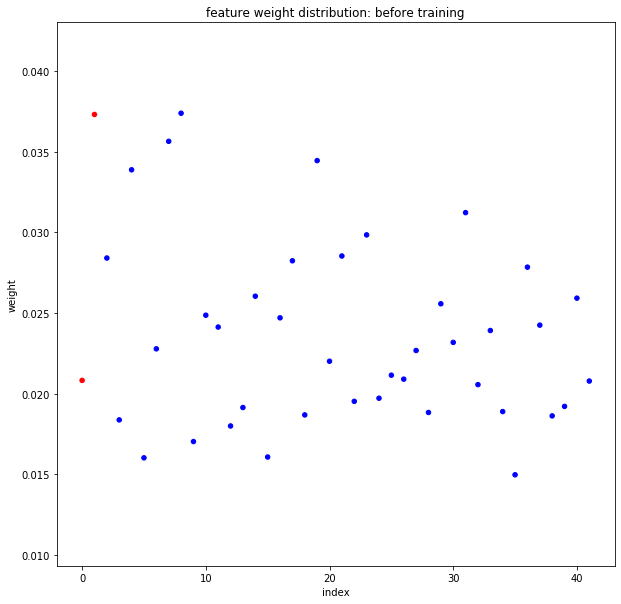

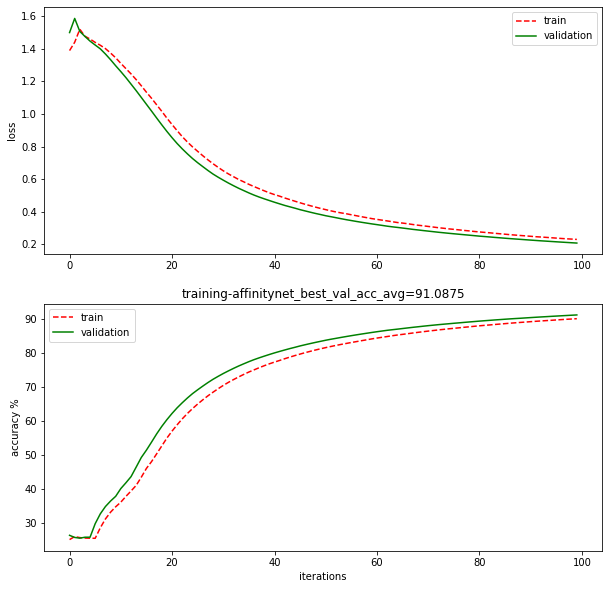

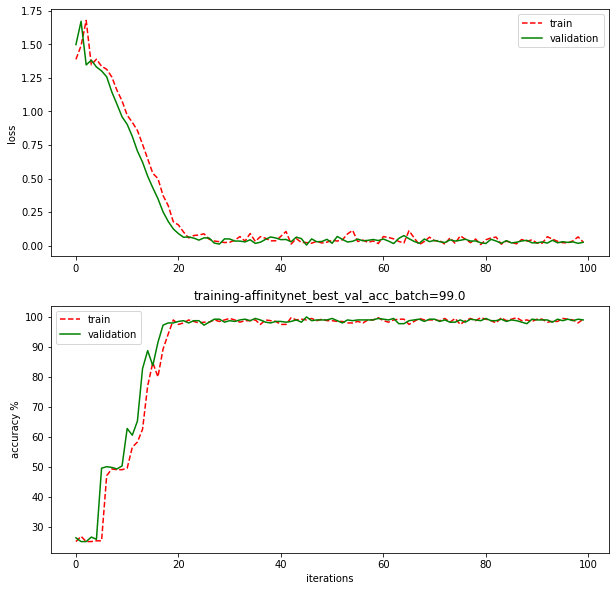

Feature weights after training
layer0: 0.4923937916755676, [0.2880563735961914, 0.2043374925851822]
overall: 0.49239384050103363, [0.2880563585728816, 0.20433748192815204]


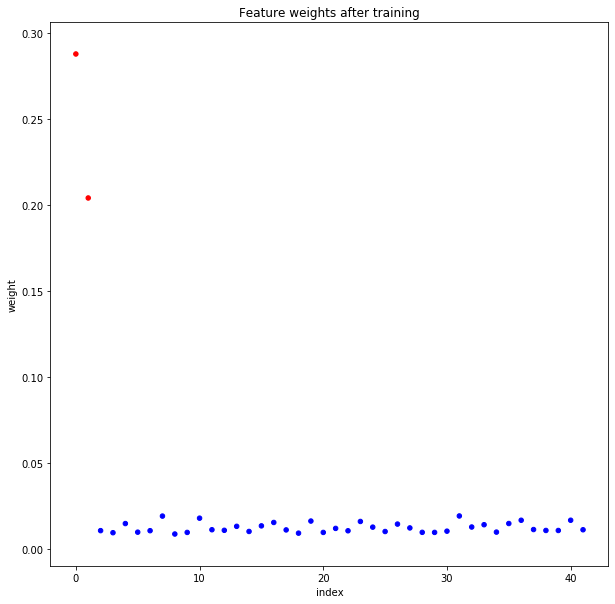

0.layers.0.components.0.a 42
1.layers.linear0.weight 4200
1.layers.linear0.bias 100
1.layers.linear1.weight 400
1.layers.linear1.bias 4
total param:4746
layers.linear0.weight 4200
layers.linear0.bias 100
layers.linear1.weight 400
layers.linear1.bias 4
total param:4704
Feature weights before training Linear
overall: 0.04260694235563278, [0.032863348722457886, 0.009743595495820045]


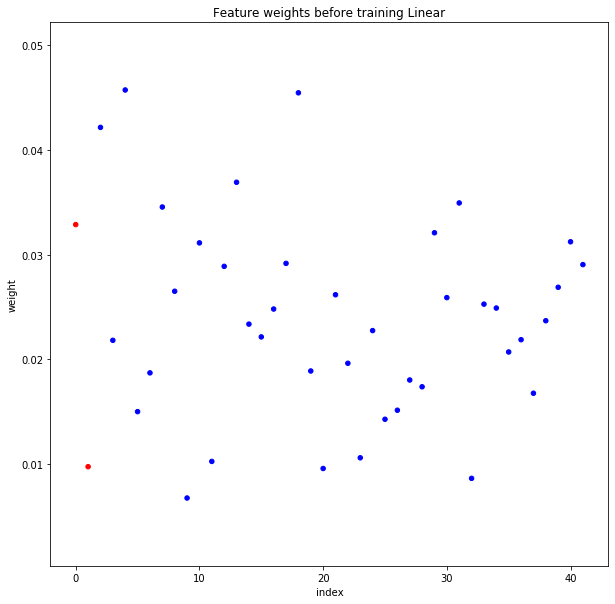

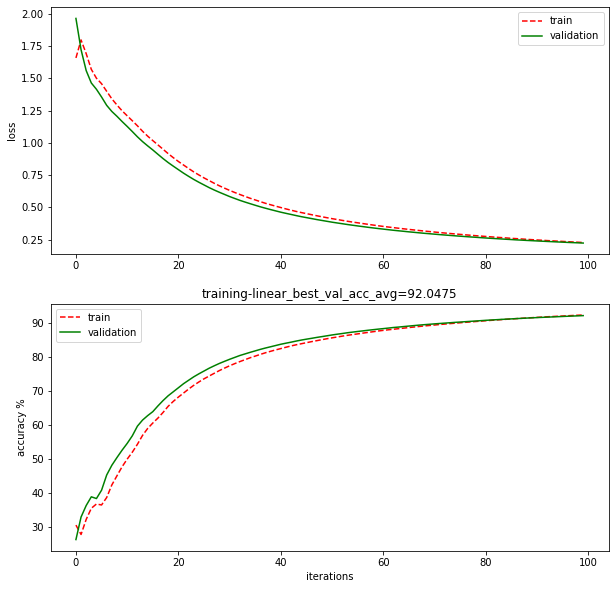

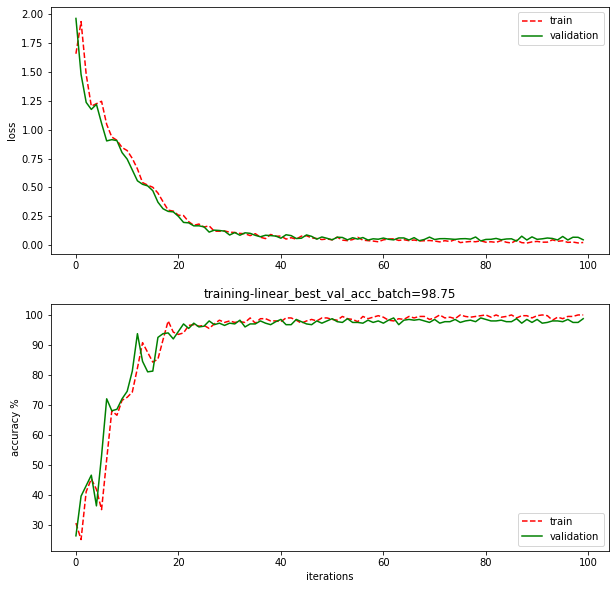

Feature weights after training Linear
overall: 0.6666650176048279, [0.33760783076286316, 0.3290571868419647]


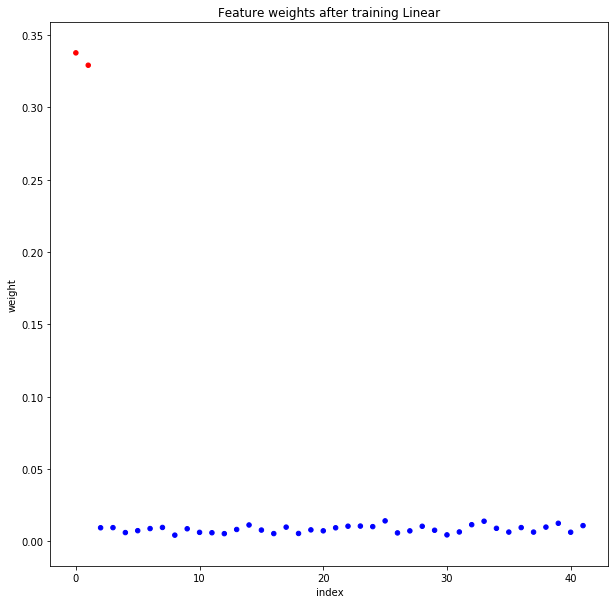

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: './data/simulation/knn_pooling_toy/seed0'

In [26]:
x_var = Variable(torch.from_numpy(x).float())
y_var = Variable(torch.from_numpy(y).long())

num_cls = y_var.data.max().item() + 1

train_portions = [0.005, 0.01, 0.1, 0.2, 0.5, 0.8]
res = {}

for train_portion in train_portions:
  proportions = [train_portion]*num_cls
  x_train, y_train, x_test, y_test, train_idx, test_idx = split_data(
      x_var, y_var, proportions=proportions, seed=seed)
  print('train size: {0}, test size: {1}'.format(y_train.size(0), y_test.size(0)))

  data = {'X_train':x_train.data, 'y_train':y_train.data, 'X_val':x_test.data, 'y_val':y_test.data, 
         'X_test':x_test.data, 'y_test':y_test.data}
  save_folder = '{0}/train_portion-{1}/'.format(save_folder_prefix, train_portion)
  """
  classifiers = [
      MLPClassifier(alpha=1),
      DecisionTreeClassifier(max_depth=5),
      AdaBoostClassifier(),
      KNeighborsClassifier(3),
      SVC(kernel="linear"),
      SVC(gamma=2, C=1),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      GaussianNB()]
  """
  res[train_portion] = compare_classifiers(x_train.data.numpy(), x_test.data.numpy(), 
                                          y_train.data.numpy(), y_test.data.numpy(), 
                                           names, classifiers)
  eval_affinitynet(data, res)

if not os.path.exists(save_folder_prefix):
  os.mkdir(save_folder_prefix)
with open('{0}/res.pkl'.format(save_folder_prefix), 'wb') as f:
  pickle.dump(res, f)
  
# with open(save_folder_prefix+'res.pkl', 'rb') as f:
#   data = pickle.load(f)